# 项目简介
数据集源自2016年上半年（即1-6月份）真实的线上线下消费行为，我们需要预测用户在2016年7月份领取优惠券后的15天内使用和消费情况 

项目目标是预测投放的优惠券是否核销 

评定标准：AUC（Area Under Curve）ROC曲线与x坐标围成的面积。

# 解决方案概述
本赛题提供了用户线下消费和优惠券领取核销行为的纪录表，用户线上点击/消费和优惠券领取核销行为的纪录表，记录的时间区间是2016.01.01至2016.06.30,需要预测的是2016年7月份用户领取优惠劵后是否核销。根据这两份数据表，我们首先对数据集进行划分，然后提取了用户相关的特征、商家相关的特征，优惠劵相关的特征，用户与商家之间的交互特征，以及利用本赛题的leakage得到的其它特征（这部分特征在实际业务中是不可能获取到的）。最后训练了XGBoost，GBDT，RandomForest进行模型融合。

In [1]:
import pandas as pd
import numpy as np
from datetime import date

# 导入文件

**off_train线下训练集**

In [2]:
off_train = pd.read_csv('ccf_offline_stage1_train.csv',low_memory=False)
# off_train.columns = ['user_id','merchant_id','coupon_id','discount_rate','distance','date_received','date']
off_train.rename(str.lower,axis='columns',inplace=True)
print(off_train.head())
off_train_rows = off_train.shape[0]
print("线下领券和消费行为表有%s行" % off_train_rows)
print("有{}条领取了优惠券的记录，一共有{}种优惠券".format(off_train.discount_rate.describe()[0],off_train.discount_rate.describe()[1]))
# print(off_train.discount_rate.describe())
# print(off_train.discount_rate.nunique())
print("一共有%s个用户" % off_train.user_id.nunique())
print("领券时间是从{}-{}".format(str(off_train.date_received.min())[:-2],str(off_train.date_received.max())[:-2]))
print("消费时间是从{}-{}".format(str(off_train.date.min())[:-2],str(off_train.date.max())[:-2]))

   user_id  merchant_id  coupon_id discount_rate  distance  date_received  \
0  1439408         2632        NaN           NaN       0.0            NaN   
1  1439408         4663    11002.0        150:20       1.0     20160528.0   
2  1439408         2632     8591.0          20:1       0.0     20160217.0   
3  1439408         2632     1078.0          20:1       0.0     20160319.0   
4  1439408         2632     8591.0          20:1       0.0     20160613.0   

         date  
0  20160217.0  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
线下领券和消费行为表有1754884行
有1053282条领取了优惠券的记录，一共有45种优惠券
一共有539438个用户
领券时间是从20160101-20160615
消费时间是从20160101-20160630


**off_test线下测试集**

In [3]:
off_test = pd.read_csv('ccf_offline_stage1_test_revised.csv',low_memory=False)
off_test.rename(str.lower,axis='columns',inplace=True)
print(off_test.head())

print("线下领券和消费行为表有%s行" % off_test.shape[0])
print("有{}条领取了优惠券的记录，一共有{}种优惠券".format(
    off_test.coupon_id.count() , off_test.discount_rate.nunique()))
print("一共有%s个用户" % off_test.user_id.nunique())
print("领券时间是从{}到{}".format(str(off_test.date_received.min()),str(off_test.date_received.max())))

# print((off_test.user_id.unique() & off_train.user_id.unique()).sum())
# print(len(set(off_test.user_id).difference(set(off_test.user_id))))# 差集，不知为什么是0而不是2
print("线下测试表有%s个用户与线下训练表有交集" % len(set(off_test.user_id).intersection(set(off_train.user_id))))# 交集
# print(len(set(off_test.user_id).union(set(off_test.user_id))))# 并集
print("线下测试表有%s个商户与线下训练表有交集" % len(set(off_test.merchant_id ).intersection(set(off_train.merchant_id ))))
"""
2050 coupon_id. 
date_received:20160701~20160731, 
76309 users(76307 in trainset, 35965 in online_trainset), 
1559 merchants(1558 in trainset)
"""

   user_id  merchant_id  coupon_id discount_rate  distance  date_received
0  4129537          450       9983          30:5       1.0       20160712
1  6949378         1300       3429          30:5       NaN       20160706
2  2166529         7113       6928        200:20       5.0       20160727
3  2166529         7113       1808        100:10       5.0       20160727
4  6172162         7605       6500          30:1       2.0       20160708
线下领券和消费行为表有113640行
有113640条领取了优惠券的记录，一共有42种优惠券
一共有76309个用户
领券时间是从20160701到20160731
线下测试表有76307个用户与线下训练表有交集
线下测试表有1558个商户与线下训练表有交集


'\n2050 coupon_id. \ndate_received:20160701~20160731, \n76309 users(76307 in trainset, 35965 in online_trainset), \n1559 merchants(1558 in trainset)\n'

**on_train线上训练集**

In [4]:
on_train = pd.read_csv('ccf_online_stage1_train.csv',low_memory=False)
on_train.rename(str.lower,axis='columns',inplace=True)
# print(on_train.shape)
# print(len(set(off_test.user_id).intersection(set(on_train.user_id))))
#11429826 record(872357 with coupon_id),762858 user(267448 in off_train)
print(on_train.head())

print("线下领券和消费行为表有%s行" % on_train.shape[0])
print("有{}条领取了优惠券的记录，一共有{}种优惠券".format(
    on_train.coupon_id.count() , on_train.discount_rate.nunique()))
print("一共有%s个用户" % on_train.user_id.nunique())
print("领券时间是从{}到{}".format(str(on_train.date_received.min())[:-2],str(on_train.date_received.max())[:-2]))
print("消费时间是从{}到{}".format(str(on_train.date.min())[:-2],str(on_train.date.max())[:-2]))

    user_id  merchant_id  action  coupon_id discount_rate  date_received  \
0  13740231        18907       2  100017492        500:50     20160513.0   
1  13740231        34805       1        NaN           NaN            NaN   
2  14336199        18907       0        NaN           NaN            NaN   
3  14336199        18907       0        NaN           NaN            NaN   
4  14336199        18907       0        NaN           NaN            NaN   

         date  
0         NaN  
1  20160321.0  
2  20160618.0  
3  20160618.0  
4  20160618.0  
线下领券和消费行为表有11429826行
有872357条领取了优惠券的记录，一共有64种优惠券
一共有762858个用户
领券时间是从20160101到20160615
消费时间是从20160101到20160630


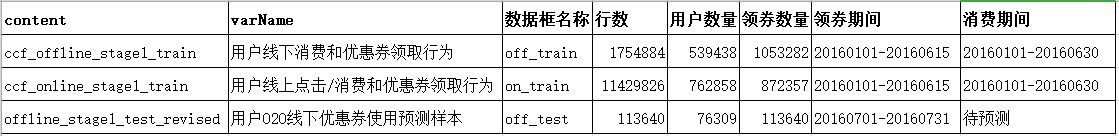

# 数据集划分
可以采用滑窗的方法得到多份训练数据集，特征区间越小，得到的训练数据集越多。以下是一种划分方式： 
![jupyter](./split.png)
划取多份训练集，一方面可以增加训练样本，另一方面可以做交叉验证实验，方便调参。

In [5]:
# 测试集3，取线下测试集领券日期在7月1日到7月31日的记录
dataset3 = off_test
# 特征集3，取线下训练集消费日期在3月15日-6月30日之间的记录或者没有消费但领券时间在3月15日-6月30日之间的记录
feature3 = off_train[((off_train.date>=20160315)&(off_train.date<=20160630))|(off_train.date.isnull()&(off_train.date_received>=20160315)&(off_train.date_received<=20160630))]

# 训练集2， 取线下训练集领券日期在5月15日-6月15日之间的记录
dataset2 = off_train[(off_train.date_received>=20160515)&(off_train.date_received<=20160615)]
# 特征集2，取线下训练集消费日期在2月1日-5月14日之间的记录或者没有消费但领券时间在2月1日-5月14日之间的记录
feature2 = off_train[(off_train.date>=20160201)&(off_train.date<=20160514)|((off_train.date.isnull())&(off_train.date_received>=20160201)&(off_train.date_received<=20160514))]

# 训练集1，取线下训练集领券日期在4月14日-5月14日之间的记录
dataset1 = off_train[(off_train.date_received>=20160414)&(off_train.date_received<=20160514)]
# 特征集1，取线下训练集消费日期在1月1日-4月13日之间的记录或者没有消费但领券时间在1月1日-4月13日之间的记录
feature1 = off_train[(off_train.date>=20160101)&(off_train.date<=20160413)|((off_train.date.isnull())&(off_train.date_received>=20160101)&(off_train.date_received<=20160413))]

In [6]:
print(feature3.isnull().sum())
print(feature2.isnull().sum())
print(feature1.isnull().sum())

user_id               0
merchant_id           0
coupon_id        499021
discount_rate    499021
distance          57463
date_received    499021
date             482796
dtype: int64
user_id               0
merchant_id           0
coupon_id        386379
discount_rate    386379
distance          43760
date_received    386379
date             387487
dtype: int64
user_id               0
merchant_id           0
coupon_id        339013
discount_rate    339013
distance          60999
date_received    339013
date             619856
dtype: int64


# 特征工程
赛题提供了online和offline两份数据集，online数据集可以提取到与用户相关的特征，offline数据集可以提取到更加丰富的特征：用户相关的特征，商家相关的特征，优惠劵相关的特征，用户-商家交互特征。

另外需要指出的是，赛题提供的预测集中，包含了同一个用户在整个7月份里的优惠券领取情况，这实际上是一种leakage，比如存在这种情况：某一个用户在7月10日领取了某优惠券，然后在7月12日和7月15日又领取了相同的优惠券，那么7月10日领取的优惠券被核销的可能性就很大了。我们在做特征工程时也注意到了这一点，提取了一些相关的特征。加入这部分特征后，AUC提升了10个百分点，相信大多数队伍都利用了这一leakage，但这些特征在实际业务中是无法获取到的。

###   other feature-数据集三

从dataset3中提取 
t（本月用户领券的次数） 

t1（本月同一用户领取同一个优惠券的次数）  

t2（得到每个领取过多次优惠券的用户最早和最晚一次领券时间）  

t3（记录了用户是否第一次领券或者最后一次领券（1为是，0为否，-1为只领过一次券））  

t4（记录这一天用户收到所有优惠券合计） 

t5（记录这一天用户收到相同优惠券合计） 

t7（记录了本次领券早于上次的间隔天数，和晚于上次的间隔天数）

In [7]:
#for dataset3
t = dataset3[['user_id']].copy()
# 增加一个变量：用户本月领券总次数
t['this_month_user_receive_all_coupon_count'] = 1
# 分组后聚合，重置索引
t = t.groupby('user_id').agg('sum').reset_index()

# 新增一个变量：本月领券同一优惠券的次数
t1 = dataset3[['user_id','coupon_id']].copy()
t1['this_month_user_receive_same_coupon_count'] = 1
t1 = t1.groupby(['user_id','coupon_id']).agg('sum').reset_index()
print(t1.head())

t2 = dataset3[['user_id','coupon_id','date_received']].copy()
t2.date_received = t2.date_received.astype('str')
# 显示用户领取同一优惠券的全部时间，以：分隔
t2 = t2.groupby(['user_id','coupon_id'])['date_received'].agg(lambda x:':'.join(x)).reset_index()

# 记录领取过两次或以上的用户
t2['receive_number'] = t2.date_received.apply(lambda s:len(s.split(':')))
t2 = t2[t2.receive_number>1]
# 最后一次领取优惠券是什么时候
t2['max_date_received'] = t2.date_received.apply(lambda s:max([int(d) for d in s.split(':')]))
# 最早领取优惠券是什么时候
t2['min_date_received'] = t2.date_received.apply(lambda s:min([int(d) for d in s.split(':')]))
# 得到每个领取过多次优惠券的用户最早和最晚一次领券时间
t2 = t2[['user_id','coupon_id','max_date_received','min_date_received']].copy()
print(t2.head())
# print(t2.isnull().sum())

   user_id  coupon_id  this_month_user_receive_same_coupon_count
0      209        825                                          1
1      209       7557                                          1
2      215       5488                                          1
3      316       3992                                          1
4      417      12465                                          1
     user_id  coupon_id  max_date_received  min_date_received
6        448      10927           20160710           20160704
13       736       3686           20160724           20160713
24      1318      11894           20160728           20160720
128     9208       6335           20160716           20160703
155    11170      11873           20160730           20160715


In [8]:
t3 = dataset3[['user_id','coupon_id','date_received']].copy()
# 将最早和最晚领券时间添加到原数据集
t3 = pd.merge(t3,t2,on=['user_id','coupon_id'],how='left')

# 删除异常值
# t3 = t3[t3.date_received!='Date_received']
# t3.date_received = t3.date_received.astype("int")
# 计算本月用户领券距离最后一次领券的时间间隔
t3['this_month_user_receive_same_coupon_lastone'] = t3.max_date_received - t3.date_received
# # 计算本月用户领券距离第一次领券的时间间隔
t3['this_month_user_receive_same_coupon_firstone'] = t3.date_received - t3.min_date_received

def is_firstlastone(x):
    if x==0:
        return 1
    elif x>0:
        return 0
    else:
        return -1 # those only receive once
        
t3.this_month_user_receive_same_coupon_lastone = t3.this_month_user_receive_same_coupon_lastone.apply(is_firstlastone)
t3.this_month_user_receive_same_coupon_firstone = t3.this_month_user_receive_same_coupon_firstone.apply(is_firstlastone)
t3 = t3[['user_id','coupon_id','date_received','this_month_user_receive_same_coupon_lastone','this_month_user_receive_same_coupon_firstone']]
# t3记录了用户是否第一次领券或者最后一次领券（1为是，0为否，-1为只领过一次券）
print(t3.head())
# print(t3.isnull().sum())

   user_id  coupon_id  date_received  \
0  4129537       9983       20160712   
1  6949378       3429       20160706   
2  2166529       6928       20160727   
3  2166529       1808       20160727   
4  6172162       6500       20160708   

   this_month_user_receive_same_coupon_lastone  \
0                                           -1   
1                                           -1   
2                                           -1   
3                                           -1   
4                                           -1   

   this_month_user_receive_same_coupon_firstone  
0                                            -1  
1                                            -1  
2                                            -1  
3                                            -1  
4                                            -1  


### 问题
1.在运行（t3['this_month_user_receive_same_coupon_lastone'] = t3.max_date_received - t3.date_received）时 

报错：TypeError: unsupported operand type(s) for -: 'float' and 'str' 

原因是： t3.date_received.dtype为对象（type("0")）,该列中包含一个'Date_received'，先删除该行再转换成数值型即可 


In [9]:
t4 = dataset3[['user_id','date_received']].copy()
# 计算这一天用户收到所有优惠券合计
t4['this_day_user_receive_all_coupon_count'] = 1
t4 = t4.groupby(['user_id','date_received']).agg('sum').reset_index()

t5 = dataset3[['user_id','coupon_id','date_received']].copy()
# 计算这一天用户收到相同优惠券合计
t5['this_day_user_receive_same_coupon_count'] = 1
t5 = t5.groupby(['user_id','coupon_id','date_received']).agg('sum').reset_index()

t6 = dataset3[['user_id','coupon_id','date_received']].copy()
t6.date_received = t6.date_received.astype('str')
t6 = t6.groupby(['user_id','coupon_id'])['date_received'].agg(lambda x:':'.join(x)).reset_index()
t6.rename(columns={'date_received':'dates'},inplace=True)
print(t6.head())
# print(t6.isnull().sum())

   user_id  coupon_id     dates
0      209        825  20160721
1      209       7557  20160721
2      215       5488  20160703
3      316       3992  20160721
4      417      12465  20160712


计算时间间隔

In [10]:
def get_day_gap_before(s):
    # 本次领券时间-全部领券时间的集合
    date_received,dates = s.split('-')
    dates = dates.split(':')
    gaps = []
    for d in dates:
        # 本次领券时间分别与全部领券时间的间隔天数
        this_gap = (date(int(date_received[0:4]),int(date_received[4:6]),int(date_received[6:8]))-date(int(d[0:4]),int(d[4:6]),int(d[6:8]))).days
        # 若本次领券时间不是第一次领券，则将本次领券时间与其他早于本次的时间的间隔天数记录于gaps中
        if this_gap>0:
            gaps.append(this_gap)
    # 如果本次领券时间都是第一次，即该用户只领过一次券        
    if len(gaps)==0:
        return -1
    # 如果本次领券不是唯一一次，返回最小的间隔天数
    else:
        return min(gaps)
        
def get_day_gap_after(s):
    date_received,dates = s.split('-')
    dates = dates.split(':')
    gaps = []
    for d in dates:
        this_gap = (date(int(d[0:4]),int(d[4:6]),int(d[6:8]))-date(int(date_received[0:4]),int(date_received[4:6]),int(date_received[6:8]))).days
        # 若本次领券时间不是最后一次领券，则将本次领券时间与其他晚于本次的时间的间隔天数记录于gaps中
        if this_gap>0:
            gaps.append(this_gap)
    # 该用户只领过一次券         
    if len(gaps)==0:
        return -1
    else:
        # 如果本次领券不是唯一一次，返回最小的间隔天数
        return min(gaps)

In [11]:
t7 = dataset3[['user_id','coupon_id','date_received']].copy()
t7 = pd.merge(t7,t6,on=['user_id','coupon_id'],how='left')
# 显示本次领券时间和全部领券时间
t7['date_received_date'] = t7.date_received.astype('str') + '-' + t7.dates
# t7 = t7[t7.date_received!='Date_received']
t7.date_received = t7.date_received.astype("int")
# 计算本次领券时间早于第一次领券时间的天数
t7['day_gap_before'] = t7.date_received_date.apply(get_day_gap_before)
# 计算本次领券时间晚于最后一次领券时间的天数
t7['day_gap_after'] = t7.date_received_date.apply(get_day_gap_after)
t7 = t7[['user_id','coupon_id','date_received','day_gap_before','day_gap_after']]
# t7记录了本次领券时间早于其他领券时间的最小间隔天数，和晚于其他领券时间的最小间隔天数(-1表示只领过一次券)
print(t7.head())
# print(t7.isnull().sum())

   user_id  coupon_id  date_received  day_gap_before  day_gap_after
0  4129537       9983       20160712              -1             -1
1  6949378       3429       20160706              -1             -1
2  2166529       6928       20160727              -1             -1
3  2166529       1808       20160727              -1             -1
4  6172162       6500       20160708              -1             -1


**合并所需的特征形成other_feature3数据集**

In [12]:
other_feature3 = pd.merge(t1,t,on='user_id')
other_feature3 = pd.merge(other_feature3,t3,on=['user_id','coupon_id'])
# 此处出现问题You are trying to merge on int32 and object columns. If you wish to proceed you should use pd.concat
# t4 = t4[t4.date_received!='Date_received']
t4['date_received'] = t4['date_received'].astype("int")
other_feature3 = pd.merge(other_feature3,t4,on=['user_id','date_received'])
# t5 = t5[t5.date_received!='Date_received']
t5['date_received'] = t5['date_received'].astype("int")
other_feature3 = pd.merge(other_feature3,t5,on=['user_id','coupon_id','date_received'])
other_feature3 = pd.merge(other_feature3,t7,on=['user_id','coupon_id','date_received'])
other_feature3.to_csv('data/other_feature3.csv',index=None)
print(other_feature3.shape)
other_feature3.head()
# print(other_feature3.isnull().sum())

(116204, 11)


,user_id,coupon_id,this_month_user_receive_same_coupon_count,this_month_user_receive_all_coupon_count,date_received,this_month_user_receive_same_coupon_lastone,this_month_user_receive_same_coupon_firstone,this_day_user_receive_all_coupon_count,this_day_user_receive_same_coupon_count,day_gap_before,day_gap_after
0,209,825,1,2,20160721,-1,-1,2,1,-1,-1
1,209,7557,1,2,20160721,-1,-1,2,1,-1,-1
2,215,5488,1,1,20160703,-1,-1,1,1,-1,-1
3,316,3992,1,1,20160721,-1,-1,1,1,-1,-1
4,417,12465,1,1,20160712,-1,-1,1,1,-1,-1


###   other feature - 数据集二

In [13]:
#for dataset2
t = dataset2[['user_id']].copy()
t['this_month_user_receive_all_coupon_count'] = 1
t = t.groupby('user_id').agg('sum').reset_index()

t1 = dataset2[['user_id','coupon_id']].copy()
t1['this_month_user_receive_same_coupon_count'] = 1
t1 = t1.groupby(['user_id','coupon_id']).agg('sum').reset_index()

t2 = dataset2[['user_id','coupon_id','date_received']].copy()
t2.date_received = t2.date_received.astype('str')
t2 = t2.groupby(['user_id','coupon_id'])['date_received'].agg(lambda x:':'.join(x)).reset_index()
t2['receive_number'] = t2.date_received.apply(lambda s:len(s.split(':')))
t2 = t2[t2.receive_number>1]
t2['max_date_received'] = t2.date_received.apply(lambda s:max([int(d[:-2]) for d in s.split(':')]))
t2['min_date_received'] = t2.date_received.apply(lambda s:min([int(d[:-2]) for d in s.split(':')]))
t2 = t2[['user_id','coupon_id','max_date_received','min_date_received']]

t3 = dataset2[['user_id','coupon_id','date_received']].copy()
t3 = pd.merge(t3,t2,on=['user_id','coupon_id'],how='left')
t3['this_month_user_receive_same_coupon_lastone'] = t3.max_date_received - t3.date_received.astype('int')
t3['this_month_user_receive_same_coupon_firstone'] = t3.date_received.astype('int') - t3.min_date_received
def is_firstlastone(x):
    if x==0:
        return 1
    elif x>0:
        return 0
    else:
        return -1 #those only receive once
        
t3.this_month_user_receive_same_coupon_lastone = t3.this_month_user_receive_same_coupon_lastone.apply(is_firstlastone)
t3.this_month_user_receive_same_coupon_firstone = t3.this_month_user_receive_same_coupon_firstone.apply(is_firstlastone)
t3 = t3[['user_id','coupon_id','date_received','this_month_user_receive_same_coupon_lastone','this_month_user_receive_same_coupon_firstone']]

t4 = dataset2[['user_id','date_received']].copy()
t4['this_day_user_receive_all_coupon_count'] = 1
t4 = t4.groupby(['user_id','date_received']).agg('sum').reset_index()

t5 = dataset2[['user_id','coupon_id','date_received']].copy()
t5['this_day_user_receive_same_coupon_count'] = 1
t5 = t5.groupby(['user_id','coupon_id','date_received']).agg('sum').reset_index()

t6 = dataset2[['user_id','coupon_id','date_received']].copy()
t6.date_received = t6.date_received.astype('str')
t6 = t6.groupby(['user_id','coupon_id'])['date_received'].agg(lambda x:':'.join(x)).reset_index()
t6.rename(columns={'date_received':'dates'},inplace=True)

def get_day_gap_before(s):
    date_received,dates = s.split('-')
    dates = dates.split(':')
    gaps = []
    for d in dates:
        this_gap = (date(int(date_received[0:4]),int(date_received[4:6]),int(date_received[6:8]))-date(int(d[0:4]),int(d[4:6]),int(d[6:8]))).days
        if this_gap>0:
            gaps.append(this_gap)
    if len(gaps)==0:
        return -1
    else:
        return min(gaps)
        
def get_day_gap_after(s):
    date_received,dates = s.split('-')
    dates = dates.split(':')
    gaps = []
    for d in dates:
        this_gap = (date(int(d[0:4]),int(d[4:6]),int(d[6:8]))-date(int(date_received[0:4]),int(date_received[4:6]),int(date_received[6:8]))).days
        if this_gap>0:
            gaps.append(this_gap)
    if len(gaps)==0:
        return -1
    else:
        return min(gaps)
    

t7 = dataset2[['user_id','coupon_id','date_received']].copy()
t7 = pd.merge(t7,t6,on=['user_id','coupon_id'],how='left')
t7['date_received_date'] = t7.date_received.astype('str') + '-' + t7.dates
t7['day_gap_before'] = t7.date_received_date.apply(get_day_gap_before)
t7['day_gap_after'] = t7.date_received_date.apply(get_day_gap_after)
t7 = t7[['user_id','coupon_id','date_received','day_gap_before','day_gap_after']]

other_feature2 = pd.merge(t1,t,on='user_id')
other_feature2 = pd.merge(other_feature2,t3,on=['user_id','coupon_id'])
other_feature2 = pd.merge(other_feature2,t4,on=['user_id','date_received'])
other_feature2 = pd.merge(other_feature2,t5,on=['user_id','coupon_id','date_received'])
other_feature2 = pd.merge(other_feature2,t7,on=['user_id','coupon_id','date_received'])
other_feature2.to_csv('data/other_feature2.csv',index=None)
# print(other_feature2.columns)
print(other_feature2.shape)
print(other_feature2.head())
# print(other_feature2.isnull().sum())


(262240, 11)
   user_id  coupon_id  this_month_user_receive_same_coupon_count  \
0        4     2902.0                                          1   
1      165     7571.0                                          1   
2      166     9261.0                                          1   
3      215     8944.0                                          1   
4      236    11002.0                                          1   

   this_month_user_receive_all_coupon_count  date_received  \
0                                         1     20160607.0   
1                                         1     20160525.0   
2                                         1     20160525.0   
3                                         1     20160524.0   
4                                         1     20160528.0   

   this_month_user_receive_same_coupon_lastone  \
0                                           -1   
1                                           -1   
2                                           -1   
3    

###   other feature - 数据集一

In [14]:
#for dataset1
t = dataset1[['user_id']].copy()
t['this_month_user_receive_all_coupon_count'] = 1
t = t.groupby('user_id').agg('sum').reset_index()

t1 = dataset1[['user_id','coupon_id']].copy()
t1['this_month_user_receive_same_coupon_count'] = 1
t1 = t1.groupby(['user_id','coupon_id']).agg('sum').reset_index()

t2 = dataset1[['user_id','coupon_id','date_received']]
t2.date_received = t2.date_received.astype('str')
t2 = t2.groupby(['user_id','coupon_id'])['date_received'].agg(lambda x:':'.join(x)).reset_index()
t2['receive_number'] = t2.date_received.apply(lambda s:len(s.split(':')))
t2 = t2[t2.receive_number>1]
t2['max_date_received'] = t2.date_received.apply(lambda s:max([int(d[:-2]) for d in s.split(':')]))
t2['min_date_received'] = t2.date_received.apply(lambda s:min([int(d[:-2]) for d in s.split(':')]))
t2 = t2[['user_id','coupon_id','max_date_received','min_date_received']]

t3 = dataset1[['user_id','coupon_id','date_received']]
t3 = pd.merge(t3,t2,on=['user_id','coupon_id'],how='left')
t3['this_month_user_receive_same_coupon_lastone'] = t3.max_date_received - t3.date_received.astype('int')
t3['this_month_user_receive_same_coupon_firstone'] = t3.date_received.astype('int') - t3.min_date_received
def is_firstlastone(x):
    if x==0:
        return 1
    elif x>0:
        return 0
    else:
        return -1 #those only receive once
        
t3.this_month_user_receive_same_coupon_lastone = t3.this_month_user_receive_same_coupon_lastone.apply(is_firstlastone)
t3.this_month_user_receive_same_coupon_firstone = t3.this_month_user_receive_same_coupon_firstone.apply(is_firstlastone)
t3 = t3[['user_id','coupon_id','date_received','this_month_user_receive_same_coupon_lastone','this_month_user_receive_same_coupon_firstone']]

t4 = dataset1[['user_id','date_received']].copy()
t4['this_day_user_receive_all_coupon_count'] = 1
t4 = t4.groupby(['user_id','date_received']).agg('sum').reset_index()

t5 = dataset1[['user_id','coupon_id','date_received']].copy()
t5['this_day_user_receive_same_coupon_count'] = 1
t5 = t5.groupby(['user_id','coupon_id','date_received']).agg('sum').reset_index()

t6 = dataset1[['user_id','coupon_id','date_received']].copy()
t6.date_received = t6.date_received.astype('str')
t6 = t6.groupby(['user_id','coupon_id'])['date_received'].agg(lambda x:':'.join(x)).reset_index()
t6.rename(columns={'date_received':'dates'},inplace=True)

def get_day_gap_before(s):
    date_received,dates = s.split('-')
    dates = dates.split(':')
    gaps = []
    for d in dates:
        this_gap = (date(int(date_received[0:4]),int(date_received[4:6]),int(date_received[6:8]))-date(int(d[0:4]),int(d[4:6]),int(d[6:8]))).days
        if this_gap>0:
            gaps.append(this_gap)
    if len(gaps)==0:
        return -1
    else:
        return min(gaps)
        
def get_day_gap_after(s):
    date_received,dates = s.split('-')
    dates = dates.split(':')
    gaps = []
    for d in dates:
        this_gap = (date(int(d[0:4]),int(d[4:6]),int(d[6:8]))-date(int(date_received[0:4]),int(date_received[4:6]),int(date_received[6:8]))).days
        if this_gap>0:
            gaps.append(this_gap)
    if len(gaps)==0:
        return -1
    else:
        return min(gaps)
    

t7 = dataset1[['user_id','coupon_id','date_received']].copy()
t7 = pd.merge(t7,t6,on=['user_id','coupon_id'],how='left')
t7['date_received_date'] = t7.date_received.astype('str') + '-' + t7.dates
t7['day_gap_before'] = t7.date_received_date.apply(get_day_gap_before)
t7['day_gap_after'] = t7.date_received_date.apply(get_day_gap_after)
t7 = t7[['user_id','coupon_id','date_received','day_gap_before','day_gap_after']].copy()

other_feature1 = pd.merge(t1,t,on='user_id')
other_feature1 = pd.merge(other_feature1,t3,on=['user_id','coupon_id'])
other_feature1 = pd.merge(other_feature1,t4,on=['user_id','date_received'])
other_feature1 = pd.merge(other_feature1,t5,on=['user_id','coupon_id','date_received'])
other_feature1 = pd.merge(other_feature1,t7,on=['user_id','coupon_id','date_received'])
other_feature1.to_csv('data/other_feature1.csv',index=None)
print(other_feature1.shape)
print(other_feature1.head())

C:\Users\v_ajuandeng\AppData\Local\anaconda\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


(139785, 11)
   user_id  coupon_id  this_month_user_receive_same_coupon_count  \
0      173     7610.0                                          1   
1      285     1532.0                                          1   
2      316     8952.0                                          1   
3      377     2857.0                                          1   
4      387     7610.0                                          1   

   this_month_user_receive_all_coupon_count  date_received  \
0                                         1     20160414.0   
1                                         1     20160501.0   
2                                         1     20160430.0   
3                                         1     20160512.0   
4                                         1     20160421.0   

   this_month_user_receive_same_coupon_lastone  \
0                                           -1   
1                                           -1   
2                                           -1   
3    

### coupon related feature(优惠券相关特征)
      discount_rate（折扣率）
      
      discount_man（满减门槛）
      
      discount_jian（满减金额）
      
      is_man_jian（是否满减）
      
      day_of_week（星期） 
      
      day_of_month（月份） (date_received)

In [15]:
def calc_discount_rate(s):
    s =str(s)
    s = s.split(':')
    if len(s)==1:
        # 显示折扣率
        return float(s[0])
    else:
        # 将满减形式改为折扣率形式
        return 1.0-float(s[1])/float(s[0])

def get_discount_man(s):
    s =str(s)
    s = s.split(':')
    if len(s)==1:
        # 折扣率
        return 'null'
    else:
        return int(s[0])
        
def get_discount_jian(s):
    s =str(s)
    s = s.split(':')
    if len(s)==1:
        return 'null'
    else:
        return int(s[1])

def is_man_jian(s):
    s =str(s)
    s = s.split(':')
    if len(s)==1:
        return 0
    else:
        return 1

# dataset3
# 添加星期列
dataset3['day_of_week'] = dataset3.date_received.astype('str').apply(lambda x:date(int(x[0:4]),int(x[4:6]),int(x[6:8])).weekday()+1)
# 添加月份
dataset3['day_of_month'] = dataset3.date_received.astype('str').apply(lambda x:int(x[6:8]))
# 领券日期距离6月30日（特征提取区间最后一天）的天数
dataset3['days_distance'] = dataset3.date_received.astype('str').apply(lambda x:(date(int(x[0:4]),int(x[4:6]),int(x[6:8]))-date(2016,6,30)).days)
# discount_rate有：号（满减）的取满减的门槛金额，无:(只显示折扣率)的变为null
# discount_man满减门槛
dataset3['discount_man'] = dataset3.discount_rate.apply(get_discount_man)
# discount_jian满减金额
dataset3['discount_jian'] = dataset3.discount_rate.apply(get_discount_jian)
# 是否有满减活动，是为1
dataset3['is_man_jian'] = dataset3.discount_rate.apply(is_man_jian)
# 统一整合折扣率，将满减转换为折扣率形式
dataset3['discount_rate'] = dataset3.discount_rate.apply(calc_discount_rate)
d = dataset3[['coupon_id']].copy()
d['coupon_count'] = 1
# 优惠券数量统计,.reset_index()重新索引，不再以分组的根据为索引
d = d.groupby('coupon_id').agg('sum').reset_index()
dataset3 = pd.merge(dataset3,d,on='coupon_id',how='left')
dataset3.to_csv('data/coupon3_feature.csv',index=None)
dataset3.columns# 新添优惠券被领取次数，星期，月份，距离6月30日天数，是否满减活动，满减门槛，满减折扣率，普通折扣率

# dataset2
dataset2['day_of_week'] = dataset2.date_received.astype('str').apply(lambda x:date(int(x[0:4]),int(x[4:6]),int(x[6:8])).weekday()+1)
dataset2['day_of_month'] = dataset2.date_received.astype('str').apply(lambda x:int(x[6:8]))
# 领券时间距离5月14号（特征提取区间最后一天）间隔天数
dataset2['days_distance'] = dataset2.date_received.astype('str').apply(lambda x:(date(int(x[0:4]),int(x[4:6]),int(x[6:8]))-date(2016,5,14)).days)
dataset2['discount_man'] = dataset2.discount_rate.apply(get_discount_man)
dataset2['discount_jian'] = dataset2.discount_rate.apply(get_discount_jian)
dataset2['is_man_jian'] = dataset2.discount_rate.apply(is_man_jian)
dataset2['discount_rate'] = dataset2.discount_rate.apply(calc_discount_rate)
d = dataset2[['coupon_id']].copy()
d['coupon_count'] = 1
d = d.groupby('coupon_id').agg('sum').reset_index()
dataset2 = pd.merge(dataset2,d,on='coupon_id',how='left')
dataset2.to_csv('data/coupon2_feature.csv',index=None)

# dataset1
dataset1['day_of_week'] = dataset1.date_received.astype('str').apply(lambda x:date(int(x[0:4]),int(x[4:6]),int(x[6:8])).weekday()+1)
dataset1['day_of_month'] = dataset1.date_received.astype('str').apply(lambda x:int(x[6:8]))
dataset1['days_distance'] = dataset1.date_received.astype('str').apply(lambda x:(date(int(x[0:4]),int(x[4:6]),int(x[6:8]))-date(2016,4,13)).days)
dataset1['discount_man'] = dataset1.discount_rate.apply(get_discount_man)
dataset1['discount_jian'] = dataset1.discount_rate.apply(get_discount_jian)
dataset1['is_man_jian'] = dataset1.discount_rate.apply(is_man_jian)
dataset1['discount_rate'] = dataset1.discount_rate.apply(calc_discount_rate)
d = dataset1[['coupon_id']].copy()
d['coupon_count'] = 1
d = d.groupby('coupon_id').agg('sum').reset_index()
dataset1 = pd.merge(dataset1,d,on='coupon_id',how='left')
dataset1.to_csv('data/coupon1_feature.csv',index=None)
dataset1.head()
# print(dataset1.isnull().sum())
# distance相关特征有缺失值是因为原始特征distance只有已消费的用户或者商户才有此特征，如何填充这部分缺失值呢？
# 消费日期也一样，不过该变量不会汇入模型中所以暂时不用处理


C:\Users\v_ajuandeng\AppData\Local\anaconda\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\v_ajuandeng\AppData\Local\anaconda\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\v_ajuandeng\AppData\Local\anaconda\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

,user_id,merchant_id,coupon_id,discount_rate,distance,date_received,date,day_of_week,day_of_month,days_distance,discount_man,discount_jian,is_man_jian,coupon_count
0,1832624,3381,7610.0,0.900000,0.0,20160429.0,NaN,5,29,16,200,20,1,22281
1,163606,1569,5054.0,0.850000,10.0,20160421.0,NaN,4,21,8,200,30,1,11893
2,4061024,3381,7610.0,0.900000,10.0,20160426.0,NaN,2,26,13,200,20,1,22281
3,106443,450,3732.0,0.833333,NaN,20160429.0,NaN,5,29,16,30,5,1,8845
4,114747,1569,5054.0,0.850000,9.0,20160426.0,NaN,2,26,13,200,30,1,11893


### merchant related feature(商户相关特征)
total_sales（总消费数量）

sales_use_coupon（用优惠券消费的数量）

total_coupon（领取的总优惠券数量）

coupon_rate（使用优惠券消费占比） = sales_use_coupon/total_sales.

merchant_coupon_transfer_rate（用户在这个商户领取优惠券的核销率） = sales_use_coupon/total_coupon. 

merchant_avg_distance（用户和商户之间的平均距离）

merchant_min_distance（用户和商户之间的最小距离）

merchant_max_distance（用户和商户之间的平均距离）

In [16]:
# for dataset3
merchant3 = feature3[['merchant_id','coupon_id','distance','date_received','date']].copy()
t = merchant3[['merchant_id']].copy()
t.drop_duplicates(inplace=True)
# 已消费的商户id计数
t1 = merchant3[merchant3.date.notna()][['merchant_id']].copy()
t1['total_sales'] = 1
t1 = t1.groupby('merchant_id').agg('sum').reset_index()
# 已领券并且已消费的商户id计数
t2 = merchant3[(merchant3.date.notna())&(merchant3.coupon_id.notna())][['merchant_id']].copy()
t2['sales_use_coupon'] = 1
t2 = t2.groupby('merchant_id').agg('sum').reset_index()
# 已领券的商户id计数
t3 = merchant3[merchant3.coupon_id.notna()][['merchant_id']].copy()
t3['total_coupon'] = 1
t3 = t3.groupby('merchant_id').agg('sum').reset_index()
# 取领过优惠券并且已消费的商家id和与用户的距离
t4 = merchant3[(merchant3.date.notna())&(merchant3.coupon_id.notna())][['merchant_id','distance']].copy()
# t4.replace('null',-1,inplace=True)#无效，改用fillna
t4.fillna(value=-1,inplace=True)# 因为下一步会有比较数值的操作，所以需要将null替换
t4.distance = t4.distance.astype('int')
t4.replace(-1,np.nan,inplace=True)# 之后会取distance最小值，为了-1不参与操作，将-1值重新转换为null

# 新增一列merchant_min_distance：所有领券并且已消费的用户中距离商户距离最近的
t5 = t4.groupby('merchant_id').agg('min').reset_index()
t5.rename(columns={'distance':'merchant_min_distance'},inplace=True)
# 新增一列merchant_max_distance：所有领券并且已消费的用户中距离商户距离最远的
t6 = t4.groupby('merchant_id').agg('max').reset_index()
t6.rename(columns={'distance':'merchant_max_distance'},inplace=True)
# 所有领券并且已消费的用户与商户的平均距离
t7 = t4.groupby('merchant_id').agg('mean').reset_index()
t7.rename(columns={'distance':'merchant_mean_distance'},inplace=True)
# 领券人与商户距离中位数
t8 = t4.groupby('merchant_id').agg('median').reset_index()
t8.rename(columns={'distance':'merchant_median_distance'},inplace=True)

merchant3_feature = pd.merge(t,t1,on='merchant_id',how='left')
merchant3_feature = pd.merge(merchant3_feature,t2,on='merchant_id',how='left')
merchant3_feature = pd.merge(merchant3_feature,t3,on='merchant_id',how='left')
merchant3_feature = pd.merge(merchant3_feature,t5,on='merchant_id',how='left')
merchant3_feature = pd.merge(merchant3_feature,t6,on='merchant_id',how='left')
merchant3_feature = pd.merge(merchant3_feature,t7,on='merchant_id',how='left')
merchant3_feature = pd.merge(merchant3_feature,t8,on='merchant_id',how='left')
merchant3_feature.sales_use_coupon = merchant3_feature.sales_use_coupon.replace(np.nan,0) #已领券并已消费的数量，填充空值fillna with 0
# 优惠券被核销率
merchant3_feature['merchant_coupon_transfer_rate'] = merchant3_feature.sales_use_coupon.astype('float') / merchant3_feature.total_coupon
# 领取优惠券并消费的人数占总销售的比例
merchant3_feature['coupon_rate'] = merchant3_feature.sales_use_coupon.astype('float') / merchant3_feature.total_sales
# 领券人数去空值
merchant3_feature.total_coupon = merchant3_feature.total_coupon.replace(np.nan,0) #fillna with 0

# 填充缺失值
merchant3_feature.total_sales.fillna(value=0,inplace=True)
merchant3_feature.merchant_coupon_transfer_rate.fillna(value=0,inplace=True)
merchant3_feature.coupon_rate.fillna(value=0,inplace=True)
merchant3_feature.merchant_min_distance.fillna(value=merchant3_feature.merchant_min_distance.mean(),inplace=True)
merchant3_feature.merchant_max_distance.fillna(value=merchant3_feature.merchant_max_distance.mean(),inplace=True)
merchant3_feature.merchant_mean_distance.fillna(value=merchant3_feature.merchant_mean_distance.mean(),inplace=True)
merchant3_feature.merchant_median_distance.fillna(value=merchant3_feature.merchant_median_distance.mean(),inplace=True)

merchant3_feature.to_csv('data/merchant3_feature.csv',index=None)
print(merchant3_feature.head())
# print(merchant3_feature.isnull().sum())
# total_sales 99 # 总销售量是根据有销售记录的商户id计算得到的，如果有商户id没有销售过极为空值，所以total_sales可用0填充
# 取领过优惠券并且已消费的商家id和与用户的距离,distance相关特征是基于被领过券并且已销售的商家id，不满足其一条件的商户id都为缺失值
# 这部分缺失值怎么处理呢？是否应该增加一个01变量为是否领券和是否消费？还是直接用众数或者平均值填充？
# merchant_min_distance 4741
# merchant_max_distance 4741
# merchant_mean_distance 4741
# merchant_median_distance 4741
# merchant_coupon_transfer_rate 2930 # 优惠券核销率，缺失值源自于，存在被领券并消费之外的人，可用0填充。
# coupon_rate 99 # 领取优惠券并消费的人数占总消费的比例，缺失值源于total_sales的缺失，可用0填充。

   merchant_id  total_sales  sales_use_coupon  total_coupon  \
0         4663        393.0              39.0       11445.0   
1         2632          8.0               3.0          23.0   
2         3381       9579.0             416.0       46729.0   
3          450       7757.0            1239.0       35933.0   
4         6459         20.0               0.0          16.0   

   merchant_min_distance  merchant_max_distance  merchant_mean_distance  \
0               0.000000              10.000000                1.911765   
1               0.000000               1.000000                0.666667   
2               0.000000              10.000000                1.713580   
3               0.000000              10.000000                0.894068   
4               0.958052               3.432714                1.747155   

   merchant_median_distance  merchant_coupon_transfer_rate  coupon_rate  
0                  1.000000                       0.003408     0.099237  
1                  1.0

In [17]:
#for dataset2
merchant2 = feature2[['merchant_id','coupon_id','distance','date_received','date']].copy()

t = merchant2[['merchant_id']].copy()
t.drop_duplicates(inplace=True)

t1 = merchant2[merchant2.date.notna()][['merchant_id']]
t1['total_sales'] = 1
t1 = t1.groupby('merchant_id').agg('sum').reset_index()

t2 = merchant2[(merchant2.date.notna())&(merchant2.coupon_id.notna())][['merchant_id']].copy()
t2['sales_use_coupon'] = 1
t2 = t2.groupby('merchant_id').agg('sum').reset_index()

t3 = merchant2[merchant2.coupon_id.notna()][['merchant_id']].copy()
t3['total_coupon'] = 1
t3 = t3.groupby('merchant_id').agg('sum').reset_index()

t4 = merchant2[(merchant2.date.notna())&(merchant2.coupon_id.notna())][['merchant_id','distance']].copy()
t4.fillna(value=-1,inplace=True)
t4.distance = t4.distance.astype('int')
t4.replace(-1,np.nan,inplace=True)
t5 = t4.groupby('merchant_id').agg('min').reset_index()
t5.rename(columns={'distance':'merchant_min_distance'},inplace=True)

t6 = t4.groupby('merchant_id').agg('max').reset_index()
t6.rename(columns={'distance':'merchant_max_distance'},inplace=True)

t7 = t4.groupby('merchant_id').agg('mean').reset_index()
t7.rename(columns={'distance':'merchant_mean_distance'},inplace=True)

t8 = t4.groupby('merchant_id').agg('median').reset_index()
t8.rename(columns={'distance':'merchant_median_distance'},inplace=True)

merchant2_feature = pd.merge(t,t1,on='merchant_id',how='left')
merchant2_feature = pd.merge(merchant2_feature,t2,on='merchant_id',how='left')
merchant2_feature = pd.merge(merchant2_feature,t3,on='merchant_id',how='left')
merchant2_feature = pd.merge(merchant2_feature,t5,on='merchant_id',how='left')
merchant2_feature = pd.merge(merchant2_feature,t6,on='merchant_id',how='left')
merchant2_feature = pd.merge(merchant2_feature,t7,on='merchant_id',how='left')
merchant2_feature = pd.merge(merchant2_feature,t8,on='merchant_id',how='left')
merchant2_feature.sales_use_coupon = merchant2_feature.sales_use_coupon.replace(np.nan,0) #fillna with 0
merchant2_feature['merchant_coupon_transfer_rate'] = merchant2_feature.sales_use_coupon.astype('float') / merchant2_feature.total_coupon
merchant2_feature['coupon_rate'] = merchant2_feature.sales_use_coupon.astype('float') / merchant2_feature.total_sales
merchant2_feature.total_coupon = merchant2_feature.total_coupon.replace(np.nan,0) #fillna with 0

# 填充缺失值
merchant2_feature.total_sales.fillna(value=0,inplace=True)
merchant2_feature.merchant_coupon_transfer_rate.fillna(value=0,inplace=True)
merchant2_feature.coupon_rate.fillna(value=0,inplace=True)
merchant2_feature.merchant_min_distance.fillna(value=merchant2_feature.merchant_min_distance.mean(),inplace=True)
merchant2_feature.merchant_max_distance.fillna(value=merchant2_feature.merchant_max_distance.mean(),inplace=True)
merchant2_feature.merchant_mean_distance.fillna(value=merchant2_feature.merchant_mean_distance.mean(),inplace=True)
merchant2_feature.merchant_median_distance.fillna(value=merchant2_feature.merchant_median_distance.mean(),inplace=True)
merchant2_feature.to_csv('data/merchant2_feature.csv',index=None)
print(merchant2_feature.head())
# print(merchant2_feature.isnull().sum())

   merchant_id  total_sales  sales_use_coupon  total_coupon  \
0         2632         14.0               3.0          31.0   
1         3381      11537.0            1980.0       56499.0   
2         2099       5711.0            1497.0       12215.0   
3         1569        493.0              91.0       25173.0   
4         8390       1207.0             133.0         690.0   

   merchant_min_distance  merchant_max_distance  merchant_mean_distance  \
0                    1.0                    1.0                1.000000   
1                    0.0                   10.0                1.697002   
2                    0.0                   10.0                1.004814   
3                    0.0                   10.0                2.388235   
4                    0.0                   10.0                0.865079   

   merchant_median_distance  merchant_coupon_transfer_rate  coupon_rate  
0                       1.0                       0.096774     0.214286  
1                     

In [18]:
#for dataset1
merchant1 = feature1[['merchant_id','coupon_id','distance','date_received','date']].copy()

t = merchant1[['merchant_id']].copy()
t.drop_duplicates(inplace=True)

t1 = merchant1[merchant1.date.notna()][['merchant_id']].copy()
t1['total_sales'] = 1
t1 = t1.groupby('merchant_id').agg('sum').reset_index()

t2 = merchant1[(merchant1.date.notna())&(merchant1.coupon_id.notna())][['merchant_id']].copy()
t2['sales_use_coupon'] = 1
t2 = t2.groupby('merchant_id').agg('sum').reset_index()

t3 = merchant1[merchant1.coupon_id.notna()][['merchant_id']].copy()
t3['total_coupon'] = 1
t3 = t3.groupby('merchant_id').agg('sum').reset_index()

t4 = merchant1[(merchant1.date.notna())&(merchant1.coupon_id.notna())][['merchant_id','distance']].copy()
t4.fillna(value=-1,inplace=True)
t4.distance = t4.distance.astype('int')
t4.replace(-1,np.nan,inplace=True)
t5 = t4.groupby('merchant_id').agg('min').reset_index()
t5.rename(columns={'distance':'merchant_min_distance'},inplace=True)

t6 = t4.groupby('merchant_id').agg('max').reset_index()
t6.rename(columns={'distance':'merchant_max_distance'},inplace=True)

t7 = t4.groupby('merchant_id').agg('mean').reset_index()
t7.rename(columns={'distance':'merchant_mean_distance'},inplace=True)

t8 = t4.groupby('merchant_id').agg('median').reset_index()
t8.rename(columns={'distance':'merchant_median_distance'},inplace=True)


merchant1_feature = pd.merge(t,t1,on='merchant_id',how='left')
merchant1_feature = pd.merge(merchant1_feature,t2,on='merchant_id',how='left')
merchant1_feature = pd.merge(merchant1_feature,t3,on='merchant_id',how='left')
merchant1_feature = pd.merge(merchant1_feature,t5,on='merchant_id',how='left')
merchant1_feature = pd.merge(merchant1_feature,t6,on='merchant_id',how='left')
merchant1_feature = pd.merge(merchant1_feature,t7,on='merchant_id',how='left')
merchant1_feature = pd.merge(merchant1_feature,t8,on='merchant_id',how='left')
merchant1_feature.sales_use_coupon = merchant1_feature.sales_use_coupon.replace(np.nan,0) #fillna with 0
merchant1_feature['merchant_coupon_transfer_rate'] = merchant1_feature.sales_use_coupon.astype('float') / merchant1_feature.total_coupon
merchant1_feature['coupon_rate'] = merchant1_feature.sales_use_coupon.astype('float') / merchant1_feature.total_sales
merchant1_feature.total_coupon = merchant1_feature.total_coupon.replace(np.nan,0) #fillna with 0
# 填充缺失值
merchant1_feature.total_sales.fillna(value=0,inplace=True)
merchant1_feature.merchant_coupon_transfer_rate.fillna(value=0,inplace=True)
merchant1_feature.coupon_rate.fillna(value=0,inplace=True)
merchant1_feature.merchant_min_distance.fillna(value=merchant1_feature.merchant_min_distance.mean(),inplace=True)
merchant1_feature.merchant_max_distance.fillna(value=merchant1_feature.merchant_max_distance.mean(),inplace=True)
merchant1_feature.merchant_mean_distance.fillna(value=merchant1_feature.merchant_mean_distance.mean(),inplace=True)
merchant1_feature.merchant_median_distance.fillna(value=merchant1_feature.merchant_median_distance.mean(),inplace=True)
merchant1_feature.to_csv('data/merchant1_feature.csv',index=None)
print(merchant1_feature.head())

   merchant_id  total_sales  sales_use_coupon  total_coupon  \
0         2632         14.0               1.0          28.0   
1         3381      14962.0            2168.0      100369.0   
2         2099       5783.0            1705.0       16824.0   
3         4833        522.0             116.0        8321.0   
4         8390       1056.0             133.0         690.0   

   merchant_min_distance  merchant_max_distance  merchant_mean_distance  \
0                    1.0                    1.0                1.000000   
1                    0.0                   10.0                1.650457   
2                    0.0                   10.0                0.968072   
3                    0.0                   10.0                3.037736   
4                    0.0                   10.0                0.865079   

   merchant_median_distance  merchant_coupon_transfer_rate  coupon_rate  
0                       1.0                       0.035714     0.071429  
1                     

### user related feature(用户相关特征)
count_merchant（消费过的商户数量）

user_avg_distance（用户与消费过的全部商户的平均距离）

user_min_distance（用户距离消费过的全部商户的最短距离）

user_max_distance（用户距离消费过的全部商户的最远距离）

buy_use_coupon（消费使用优惠券的数量）

buy_total（总消费数量）

coupon_received（优惠券领取总数）

buy_use_coupon/coupon_received（领取的优惠券核销率）

buy_use_coupon/buy_total（使用优惠券消费占比）

user_date_datereceived_gap（用户从领券到消费的间隔时间）


In [19]:
def get_user_date_datereceived_gap(s):
    # 获取用户从领券到消费的间隔天数
    s = s.split(':')
    return (date(int(s[0][0:4]),int(s[0][4:6]),int(s[0][6:8])) - date(int(s[1][0:4]),int(s[1][4:6]),int(s[1][6:8]))).days


#for dataset3
user3 = feature3[['user_id','merchant_id','coupon_id','discount_rate','distance','date_received','date']].copy()

t = user3[['user_id']].copy()
t.drop_duplicates(inplace=True)
# 取已消费的用户id和商户id
t1 = user3[user3.date.notna()][['user_id','merchant_id']].copy()
t1.drop_duplicates(inplace=True)
t1.merchant_id = 1
t1 = t1.groupby('user_id').agg('sum').reset_index()
t1.rename(columns={'merchant_id':'count_merchant'},inplace=True)
# 取已领券并且已消费的用户id和距离
t2 = user3[(user3.date.notna())&(user3.coupon_id.notna())][['user_id','distance']].copy()
t2.fillna(value=-1,inplace=True)
t2.distance = t2.distance.astype('int')
t2.replace(-1,np.nan,inplace=True)
t3 = t2.groupby('user_id').agg('min').reset_index()
t3.rename(columns={'distance':'user_min_distance'},inplace=True)

t4 = t2.groupby('user_id').agg('max').reset_index()
t4.rename(columns={'distance':'user_max_distance'},inplace=True)

t5 = t2.groupby('user_id').agg('mean').reset_index()
t5.rename(columns={'distance':'user_mean_distance'},inplace=True)

t6 = t2.groupby('user_id').agg('median').reset_index()
t6.rename(columns={'distance':'user_median_distance'},inplace=True)
# 用户用优惠券消费的数量
t7 = user3[(user3.date.notna())&(user3.coupon_id.notna())][['user_id']].copy()
t7['buy_use_coupon'] = 1
t7 = t7.groupby('user_id').agg('sum').reset_index()
# 用户消费数量
t8 = user3[user3.date.notna()][['user_id']].copy()
t8['buy_total'] = 1
t8 = t8.groupby('user_id').agg('sum').reset_index()
# 用户领券数量
t9 = user3[user3.coupon_id.notna()][['user_id']].copy()
t9['coupon_received'] = 1
t9 = t9.groupby('user_id').agg('sum').reset_index()

# 取已领券并且已消费的用户记录、
t10 = user3[(user3.date_received.notna())&(user3.date.notna())][['user_id','date_received','date']].copy()
t10.date_received = t10.date_received.apply(lambda x:str(x)[:-2])
t10.date = t10.date.apply(lambda x:str(x)[:-2])
# 用户消费和领券的时间合集,
# 这里忽略了有些用户领取了很多次优惠券之后才消费，这里记录的已消费的领取优惠券的时间为哪一次呢？这对于之后计算领券和消费距离时间间隔有关
t10['user_date_datereceived_gap'] = t10.date + ":" +  t10.date_received
# print(t10['user_date_datereceived_gap'].apply(lambda s:s.count(":")).value_counts())
t10.user_date_datereceived_gap = t10.user_date_datereceived_gap.apply(get_user_date_datereceived_gap)
t10 = t10[['user_id','user_date_datereceived_gap']]

# 用户领券到消费的平均间隔天数
t11 = t10.groupby('user_id').agg('mean').reset_index()
t11.rename(columns={'user_date_datereceived_gap':'avg_user_date_datereceived_gap'},inplace=True)
# 用户领券到消费的最小间隔天数
t12 = t10.groupby('user_id').agg('min').reset_index()
t12.rename(columns={'user_date_datereceived_gap':'min_user_date_datereceived_gap'},inplace=True)
# 用户领券到消费的最大间隔天数
t13 = t10.groupby('user_id').agg('max').reset_index()
t13.rename(columns={'user_date_datereceived_gap':'max_user_date_datereceived_gap'},inplace=True)


user3_feature = pd.merge(t,t1,on='user_id',how='left')
user3_feature = pd.merge(user3_feature,t3,on='user_id',how='left')
user3_feature = pd.merge(user3_feature,t4,on='user_id',how='left')
user3_feature = pd.merge(user3_feature,t5,on='user_id',how='left')
user3_feature = pd.merge(user3_feature,t6,on='user_id',how='left')
user3_feature = pd.merge(user3_feature,t7,on='user_id',how='left')
user3_feature = pd.merge(user3_feature,t8,on='user_id',how='left')
user3_feature = pd.merge(user3_feature,t9,on='user_id',how='left')
user3_feature = pd.merge(user3_feature,t11,on='user_id',how='left')
user3_feature = pd.merge(user3_feature,t12,on='user_id',how='left')
user3_feature = pd.merge(user3_feature,t13,on='user_id',how='left')
user3_feature.count_merchant = user3_feature.count_merchant.replace(np.nan,0)
user3_feature.buy_use_coupon = user3_feature.buy_use_coupon.replace(np.nan,0)
# 用户用优惠券消费的数量占总消费数量的比例
user3_feature['buy_use_coupon_rate'] = user3_feature.buy_use_coupon.astype('float') / user3_feature.buy_total.astype('float')
# 领券优惠券总数中已消费的比例
user3_feature['user_coupon_transfer_rate'] = user3_feature.buy_use_coupon.astype('float') / user3_feature.coupon_received.astype('float')
user3_feature.buy_total = user3_feature.buy_total.replace(np.nan,0)
user3_feature.coupon_received = user3_feature.coupon_received.replace(np.nan,0)
# 填充缺失值
user3_feature.user_min_distance.fillna(value=-1,inplace=True)
user3_feature.user_max_distance.fillna(value=-1,inplace=True)
user3_feature.user_mean_distance.fillna(value=-1,inplace=True)
user3_feature.user_median_distance.fillna(value=-1,inplace=True)
user3_feature.avg_user_date_datereceived_gap.fillna(value=-1,inplace=True)
user3_feature.max_user_date_datereceived_gap.fillna(value=-1,inplace=True)
user3_feature.min_user_date_datereceived_gap.fillna(value=-1,inplace=True)
user3_feature.buy_use_coupon_rate.fillna(value=0,inplace=True)
user3_feature.user_coupon_transfer_rate.fillna(value=0,inplace=True)
user3_feature.to_csv('data/user3_feature.csv',index=None)
# print(user3_feature.head())
# print(user3_feature.isnull().sum())
# 基于领券并且已消费的用户id，平均值填充或者用-1
# user_min_distance  320676  
# user_max_distance  320676
# user_mean_distance  320676
# user_median_distance 320676
# 获取用户从领券到消费的间隔天数这个特征很重要，直接决定后期label的取值，该特征缺失说明该用户没有领券，或者没有消费，试试看取-1，但是注意后面label的取值
# avg_user_date_datereceived_gap  316780
# min_user_date_datereceived_gap  316780
# max_user_date_datereceived_gap  316780
# buy_use_coupon_rate 170895 可用0填充
# user_coupon_transfer_rate 38354  # 除了基于领券并且已消费的用户id，还有源于没有领过券的用户的缺失，可用0填充


#for dataset2
user2 = feature2[['user_id','merchant_id','coupon_id','discount_rate','distance','date_received','date']].copy()

t = user2[['user_id']].copy()
t.drop_duplicates(inplace=True)

t1 = user2[user2.date.notna()][['user_id','merchant_id']].copy()
t1.drop_duplicates(inplace=True)
t1.merchant_id = 1
t1 = t1.groupby('user_id').agg('sum').reset_index()
t1.rename(columns={'merchant_id':'count_merchant'},inplace=True)

t2 = user2[(user2.date.notna())&(user2.coupon_id.notna())][['user_id','distance']].copy()
t2.fillna(value=-1,inplace=True)
t2.distance = t2.distance.astype('int')
t2.replace(-1,np.nan,inplace=True)
t3 = t2.groupby('user_id').agg('min').reset_index()
t3.rename(columns={'distance':'user_min_distance'},inplace=True)

t4 = t2.groupby('user_id').agg('max').reset_index()
t4.rename(columns={'distance':'user_max_distance'},inplace=True)

t5 = t2.groupby('user_id').agg('mean').reset_index()
t5.rename(columns={'distance':'user_mean_distance'},inplace=True)

t6 = t2.groupby('user_id').agg('median').reset_index()
t6.rename(columns={'distance':'user_median_distance'},inplace=True)

t7 = user2[(user2.date.notna())&(user2.coupon_id.notna())][['user_id']].copy()
t7['buy_use_coupon'] = 1
t7 = t7.groupby('user_id').agg('sum').reset_index()

t8 = user2[user2.date.notna()][['user_id']].copy()
t8['buy_total'] = 1
t8 = t8.groupby('user_id').agg('sum').reset_index()

t9 = user2[user2.coupon_id.notna()][['user_id']].copy()
t9['coupon_received'] = 1
t9 = t9.groupby('user_id').agg('sum').reset_index()

t10 = user2[(user2.date_received.notna())&(user2.date.notna())][['user_id','date_received','date']].copy()
t10.date_received = t10.date_received.apply(lambda x:str(x)[:-2])
t10.date = t10.date.apply(lambda x:str(x)[:-2])
t10['user_date_datereceived_gap'] = t10.date + ":" +  t10.date_received
t10.user_date_datereceived_gap = t10.user_date_datereceived_gap.apply(get_user_date_datereceived_gap)
t10 = t10[['user_id','user_date_datereceived_gap']]

t11 = t10.groupby('user_id').agg('mean').reset_index()
t11.rename(columns={'user_date_datereceived_gap':'avg_user_date_datereceived_gap'},inplace=True)
t12 = t10.groupby('user_id').agg('min').reset_index()
t12.rename(columns={'user_date_datereceived_gap':'min_user_date_datereceived_gap'},inplace=True)
t13 = t10.groupby('user_id').agg('max').reset_index()
t13.rename(columns={'user_date_datereceived_gap':'max_user_date_datereceived_gap'},inplace=True)

user2_feature = pd.merge(t,t1,on='user_id',how='left')
user2_feature = pd.merge(user2_feature,t3,on='user_id',how='left')
user2_feature = pd.merge(user2_feature,t4,on='user_id',how='left')
user2_feature = pd.merge(user2_feature,t5,on='user_id',how='left')
user2_feature = pd.merge(user2_feature,t6,on='user_id',how='left')
user2_feature = pd.merge(user2_feature,t7,on='user_id',how='left')
user2_feature = pd.merge(user2_feature,t8,on='user_id',how='left')
user2_feature = pd.merge(user2_feature,t9,on='user_id',how='left')
user2_feature = pd.merge(user2_feature,t11,on='user_id',how='left')
user2_feature = pd.merge(user2_feature,t12,on='user_id',how='left')
user2_feature = pd.merge(user2_feature,t13,on='user_id',how='left')
user2_feature.count_merchant = user2_feature.count_merchant.replace(np.nan,0)
user2_feature.buy_use_coupon = user2_feature.buy_use_coupon.replace(np.nan,0)
user2_feature['buy_use_coupon_rate'] = user2_feature.buy_use_coupon.astype('float') / user2_feature.buy_total.astype('float')
user2_feature['user_coupon_transfer_rate'] = user2_feature.buy_use_coupon.astype('float') / user2_feature.coupon_received.astype('float')
user2_feature.buy_total = user2_feature.buy_total.replace(np.nan,0)
user2_feature.coupon_received = user2_feature.coupon_received.replace(np.nan,0)
# 填充缺失值
user2_feature.user_min_distance.fillna(value=-1,inplace=True)
user2_feature.user_max_distance.fillna(value=-1,inplace=True)
user2_feature.user_mean_distance.fillna(value=-1,inplace=True)
user2_feature.user_median_distance.fillna(value=-1,inplace=True)
user2_feature.avg_user_date_datereceived_gap.fillna(value=-1,inplace=True)
user2_feature.max_user_date_datereceived_gap.fillna(value=-1,inplace=True)
user2_feature.min_user_date_datereceived_gap.fillna(value=-1,inplace=True)
user2_feature.buy_use_coupon_rate.fillna(value=0,inplace=True)
user2_feature.user_coupon_transfer_rate.fillna(value=0,inplace=True)
user2_feature.to_csv('data/user2_feature.csv',index=None)
# print(user2_feature.head())
# print(user2_feature.isnull().sum())

#for dataset1
user1 = feature1[['user_id','merchant_id','coupon_id','discount_rate','distance','date_received','date']].copy()

t = user1[['user_id']].copy()
t.drop_duplicates(inplace=True)

t1 = user1[user1.date.notna()][['user_id','merchant_id']].copy()
t1.drop_duplicates(inplace=True)
t1.merchant_id = 1
t1 = t1.groupby('user_id').agg('sum').reset_index()
t1.rename(columns={'merchant_id':'count_merchant'},inplace=True)

t2 = user1[(user1.date.notna())&(user1.coupon_id.notna())][['user_id','distance']].copy()
t2.fillna(value=-1,inplace=True)
t2.distance = t2.distance.astype('int')
t2.replace(-1,np.nan,inplace=True)
t3 = t2.groupby('user_id').agg('min').reset_index()
t3.rename(columns={'distance':'user_min_distance'},inplace=True)

t4 = t2.groupby('user_id').agg('max').reset_index()
t4.rename(columns={'distance':'user_max_distance'},inplace=True)

t5 = t2.groupby('user_id').agg('mean').reset_index()
t5.rename(columns={'distance':'user_mean_distance'},inplace=True)

t6 = t2.groupby('user_id').agg('median').reset_index()
t6.rename(columns={'distance':'user_median_distance'},inplace=True)

t7 = user1[(user1.date.notna())&(user1.coupon_id.notna())][['user_id']].copy()
t7['buy_use_coupon'] = 1
t7 = t7.groupby('user_id').agg('sum').reset_index()

t8 = user1[user1.date.notna()][['user_id']].copy()
t8['buy_total'] = 1
t8 = t8.groupby('user_id').agg('sum').reset_index()

t9 = user1[user1.coupon_id.notna()][['user_id']].copy()
t9['coupon_received'] = 1
t9 = t9.groupby('user_id').agg('sum').reset_index()

t10 = user1[(user1.date_received.notna())&(user1.date.notna())][['user_id','date_received','date']].copy()
t10.date_received = t10.date_received.apply(lambda x:str(x)[:-2])
t10.date = t10.date.apply(lambda x:str(x)[:-2])
t10['user_date_datereceived_gap'] = t10.date + ":" +  t10.date_received
t10.user_date_datereceived_gap = t10.user_date_datereceived_gap.apply(get_user_date_datereceived_gap)
t10 = t10[['user_id','user_date_datereceived_gap']].copy()

t11 = t10.groupby('user_id').agg('mean').reset_index()
t11.rename(columns={'user_date_datereceived_gap':'avg_user_date_datereceived_gap'},inplace=True)
t12 = t10.groupby('user_id').agg('min').reset_index()
t12.rename(columns={'user_date_datereceived_gap':'min_user_date_datereceived_gap'},inplace=True)
t13 = t10.groupby('user_id').agg('max').reset_index()
t13.rename(columns={'user_date_datereceived_gap':'max_user_date_datereceived_gap'},inplace=True)

user1_feature = pd.merge(t,t1,on='user_id',how='left')
user1_feature = pd.merge(user1_feature,t3,on='user_id',how='left')
user1_feature = pd.merge(user1_feature,t4,on='user_id',how='left')
user1_feature = pd.merge(user1_feature,t5,on='user_id',how='left')
user1_feature = pd.merge(user1_feature,t6,on='user_id',how='left')
user1_feature = pd.merge(user1_feature,t7,on='user_id',how='left')
user1_feature = pd.merge(user1_feature,t8,on='user_id',how='left')
user1_feature = pd.merge(user1_feature,t9,on='user_id',how='left')
user1_feature = pd.merge(user1_feature,t11,on='user_id',how='left')
user1_feature = pd.merge(user1_feature,t12,on='user_id',how='left')
user1_feature = pd.merge(user1_feature,t13,on='user_id',how='left')
user1_feature.count_merchant = user1_feature.count_merchant.replace(np.nan,0)
user1_feature.buy_use_coupon = user1_feature.buy_use_coupon.replace(np.nan,0)
user1_feature['buy_use_coupon_rate'] = user1_feature.buy_use_coupon.astype('float') / user1_feature.buy_total.astype('float')
user1_feature['user_coupon_transfer_rate'] = user1_feature.buy_use_coupon.astype('float') / user1_feature.coupon_received.astype('float')
user1_feature.buy_total = user1_feature.buy_total.replace(np.nan,0)
user1_feature.coupon_received = user1_feature.coupon_received.replace(np.nan,0)
# 填充缺失值
user1_feature.user_min_distance.fillna(value=-1,inplace=True)
user1_feature.user_max_distance.fillna(value=-1,inplace=True)
user1_feature.user_mean_distance.fillna(value=-1,inplace=True)
user1_feature.user_median_distance.fillna(value=-1,inplace=True)
user1_feature.avg_user_date_datereceived_gap.fillna(value=-1,inplace=True)
user1_feature.max_user_date_datereceived_gap.fillna(value=-1,inplace=True)
user1_feature.min_user_date_datereceived_gap.fillna(value=-1,inplace=True)
user1_feature.buy_use_coupon_rate.fillna(value=0,inplace=True)
user1_feature.user_coupon_transfer_rate.fillna(value=0,inplace=True)
user1_feature.to_csv('data/user1_feature.csv',index=None)
# print(user1_feature.head())
# print(user1_feature.isnull().sum())

### user_merchant related feature (用户和商家关联的特征)
times_user_buy_merchant_before

user_merchant_coupon_transfer_rate(用户在这个商家的领取的优惠券核销率)

user_merchant_coupon_buy_rate（用户在这个商家消费时使用领取的优惠券消费的比例）

user_merchant_rate（用户在这家商家消费的比率（是否是常客,对于这家店的忠诚度））

user_merchant_common_buy_rate（用户不使用优惠券直接购买的比率（是否为必购品，对商品的依赖程度））

In [20]:
# for dataset3

all_user_merchant = feature3[['user_id','merchant_id']].copy()
all_user_merchant.drop_duplicates(inplace=True)

t = feature3[['user_id','merchant_id','date']].copy()
# 用户在不同商户的消费记录
t = t[t.date.notna()][['user_id','merchant_id']].copy()
t['user_merchant_buy_total'] = 1
t = t.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t.drop_duplicates(inplace=True)# 以两个索引分组时会出现重复？去重是否多余
# 用户在不同商户领券记录
t1 = feature3[['user_id','merchant_id','coupon_id']].copy()
t1 = t1[t1.coupon_id.notna()][['user_id','merchant_id']].copy()
t1['user_merchant_received'] = 1
t1 = t1.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t1.drop_duplicates(inplace=True)
# 用户在不同商户领券并且消费的记录
t2 = feature3[['user_id','merchant_id','date','date_received']].copy()
t2 = t2[(t2.date.notna())&(t2.date_received.notna())][['user_id','merchant_id']].copy()
t2['user_merchant_buy_use_coupon'] = 1
t2 = t2.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t2.drop_duplicates(inplace=True)
# 用户和商户出现的所有记录
t3 = feature3[['user_id','merchant_id']].copy()
t3['user_merchant_any'] = 1
t3 = t3.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t3.drop_duplicates(inplace=True)
# 用户未领券在商户中消费的记录
t4 = feature3[['user_id','merchant_id','date','coupon_id']].copy()
t4 = t4[(t4.date.notna())&(t4.coupon_id.isnull())][['user_id','merchant_id']].copy()
t4['user_merchant_buy_common'] = 1
t4 = t4.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t4.drop_duplicates(inplace=True)

user_merchant3 = pd.merge(all_user_merchant,t,on=['user_id','merchant_id'],how='left')
user_merchant3 = pd.merge(user_merchant3,t1,on=['user_id','merchant_id'],how='left')
user_merchant3 = pd.merge(user_merchant3,t2,on=['user_id','merchant_id'],how='left')
user_merchant3 = pd.merge(user_merchant3,t3,on=['user_id','merchant_id'],how='left')
user_merchant3 = pd.merge(user_merchant3,t4,on=['user_id','merchant_id'],how='left')
user_merchant3.user_merchant_buy_use_coupon = user_merchant3.user_merchant_buy_use_coupon.replace(np.nan,0)
user_merchant3.user_merchant_buy_common = user_merchant3.user_merchant_buy_common.replace(np.nan,0)

# 用户在这个商家的领取的优惠券核销率
user_merchant3['user_merchant_coupon_transfer_rate'] = user_merchant3.user_merchant_buy_use_coupon.astype('float') / user_merchant3.user_merchant_received.astype('float')
# 用户在这个商家的消费使用优惠券的比例
user_merchant3['user_merchant_coupon_buy_rate'] = user_merchant3.user_merchant_buy_use_coupon.astype('float') / user_merchant3.user_merchant_buy_total.astype('float')
# 用户在这家商家消费的比率（是否是常客,对于这家店的忠诚度）
user_merchant3['user_merchant_rate'] = user_merchant3.user_merchant_buy_total.astype('float') / user_merchant3.user_merchant_any.astype('float')
# 用户不使用优惠券直接购买的比率（是否为必购品，对商品的依赖程度）
user_merchant3['user_merchant_common_buy_rate'] = user_merchant3.user_merchant_buy_common.astype('float') / user_merchant3.user_merchant_buy_total.astype('float')

# 填充缺失值
user_merchant3.user_merchant_buy_total.fillna(value=0,inplace=True)
user_merchant3.user_merchant_received.fillna(value=0,inplace=True)
user_merchant3.user_merchant_coupon_transfer_rate.fillna(value=0,inplace=True)
user_merchant3.user_merchant_coupon_buy_rate.fillna(value=0,inplace=True)
user_merchant3.user_merchant_rate.fillna(value=0,inplace=True)
user_merchant3.user_merchant_common_buy_rate.fillna(value=0,inplace=True)
# user_merchant_buy_total 261091 #  用户在这个商户消费的数量
# user_merchant_received  73722 # 用户在这个商户领券的数量
# user_merchant_coupon_transfer_rate 73722 用户在这个商家的领取的优惠券核销率
# user_merchant_coupon_buy_rate 261091  用户在这个商家的消费使用优惠券的比例
# user_merchant_rate 261091 用户在这家商家消费的比率
# user_merchant_common_buy_rate 261091 用户不使用优惠券直接购买的比率
user_merchant3.to_csv('data/user_merchant3.csv',index=None)
# print(user_merchant3.head())
# print(user_merchant3.isnull().sum())

#for dataset2
all_user_merchant = feature2[['user_id','merchant_id']].copy()
all_user_merchant.drop_duplicates(inplace=True)

t = feature2[['user_id','merchant_id','date']].copy()
t = t[t.date.notna()][['user_id','merchant_id']].copy()
t['user_merchant_buy_total'] = 1
t = t.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t.drop_duplicates(inplace=True)

t1 = feature2[['user_id','merchant_id','coupon_id']].copy()
t1 = t1[t1.coupon_id.notna()][['user_id','merchant_id']].copy()
t1['user_merchant_received'] = 1
t1 = t1.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t1.drop_duplicates(inplace=True)

t2 = feature2[['user_id','merchant_id','date','date_received']].copy()
t2 = t2[(t2.date.notna())&(t2.date_received.notna())][['user_id','merchant_id']].copy()
t2['user_merchant_buy_use_coupon'] = 1
t2 = t2.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t2.drop_duplicates(inplace=True)

t3 = feature2[['user_id','merchant_id']].copy()
t3['user_merchant_any'] = 1
t3 = t3.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t3.drop_duplicates(inplace=True)

t4 = feature2[['user_id','merchant_id','date','coupon_id']].copy()
t4 = t4[(t4.date.notna())&(t4.coupon_id.isnull())][['user_id','merchant_id']]
t4['user_merchant_buy_common'] = 1
t4 = t4.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t4.drop_duplicates(inplace=True)

user_merchant2 = pd.merge(all_user_merchant,t,on=['user_id','merchant_id'],how='left')
user_merchant2 = pd.merge(user_merchant2,t1,on=['user_id','merchant_id'],how='left')
user_merchant2 = pd.merge(user_merchant2,t2,on=['user_id','merchant_id'],how='left')
user_merchant2 = pd.merge(user_merchant2,t3,on=['user_id','merchant_id'],how='left')
user_merchant2 = pd.merge(user_merchant2,t4,on=['user_id','merchant_id'],how='left')
user_merchant2.user_merchant_buy_use_coupon = user_merchant2.user_merchant_buy_use_coupon.replace(np.nan,0)
user_merchant2.user_merchant_buy_common = user_merchant2.user_merchant_buy_common.replace(np.nan,0)
user_merchant2['user_merchant_coupon_transfer_rate'] = user_merchant2.user_merchant_buy_use_coupon.astype('float') / user_merchant2.user_merchant_received.astype('float')
user_merchant2['user_merchant_coupon_buy_rate'] = user_merchant2.user_merchant_buy_use_coupon.astype('float') / user_merchant2.user_merchant_buy_total.astype('float')
user_merchant2['user_merchant_rate'] = user_merchant2.user_merchant_buy_total.astype('float') / user_merchant2.user_merchant_any.astype('float')
user_merchant2['user_merchant_common_buy_rate'] = user_merchant2.user_merchant_buy_common.astype('float') / user_merchant2.user_merchant_buy_total.astype('float')
# 填充缺失值
user_merchant2.user_merchant_buy_total.fillna(value=0,inplace=True)
user_merchant2.user_merchant_received.fillna(value=0,inplace=True)
user_merchant2.user_merchant_coupon_transfer_rate.fillna(value=0,inplace=True)
user_merchant2.user_merchant_coupon_buy_rate.fillna(value=0,inplace=True)
user_merchant2.user_merchant_rate.fillna(value=0,inplace=True)
user_merchant2.user_merchant_common_buy_rate.fillna(value=0,inplace=True)
user_merchant2.to_csv('data/user_merchant2.csv',index=None)
# print(user_merchant2.isnull().sum())

# for dataset2
all_user_merchant = feature1[['user_id','merchant_id']].copy()
all_user_merchant.drop_duplicates(inplace=True)

t = feature1[['user_id','merchant_id','date']].copy()
t = t[t.date.notna()][['user_id','merchant_id']].copy()
t['user_merchant_buy_total'] = 1
t = t.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t.drop_duplicates(inplace=True)

t1 = feature1[['user_id','merchant_id','coupon_id']].copy()
t1 = t1[t1.coupon_id.notna()][['user_id','merchant_id']].copy()
t1['user_merchant_received'] = 1
t1 = t1.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t1.drop_duplicates(inplace=True)

t2 = feature1[['user_id','merchant_id','date','date_received']].copy()
t2 = t2[(t2.date.notna())&(t2.date_received.notna())][['user_id','merchant_id']].copy()
t2['user_merchant_buy_use_coupon'] = 1
t2 = t2.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t2.drop_duplicates(inplace=True)

t3 = feature1[['user_id','merchant_id']].copy()
t3['user_merchant_any'] = 1
t3 = t3.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t3.drop_duplicates(inplace=True)

t4 = feature1[['user_id','merchant_id','date','coupon_id']].copy()
t4 = t4[(t4.date.notna())&(t4.coupon_id.isnull())][['user_id','merchant_id']].copy()
t4['user_merchant_buy_common'] = 1
t4 = t4.groupby(['user_id','merchant_id']).agg('sum').reset_index()
t4.drop_duplicates(inplace=True)

user_merchant1 = pd.merge(all_user_merchant,t,on=['user_id','merchant_id'],how='left')
user_merchant1 = pd.merge(user_merchant1,t1,on=['user_id','merchant_id'],how='left')
user_merchant1 = pd.merge(user_merchant1,t2,on=['user_id','merchant_id'],how='left')
user_merchant1 = pd.merge(user_merchant1,t3,on=['user_id','merchant_id'],how='left')
user_merchant1 = pd.merge(user_merchant1,t4,on=['user_id','merchant_id'],how='left')
user_merchant1.user_merchant_buy_use_coupon = user_merchant1.user_merchant_buy_use_coupon.replace(np.nan,0)
user_merchant1.user_merchant_buy_common = user_merchant1.user_merchant_buy_common.replace(np.nan,0)
user_merchant1['user_merchant_coupon_transfer_rate'] = user_merchant1.user_merchant_buy_use_coupon.astype('float') / user_merchant1.user_merchant_received.astype('float')
user_merchant1['user_merchant_coupon_buy_rate'] = user_merchant1.user_merchant_buy_use_coupon.astype('float') / user_merchant1.user_merchant_buy_total.astype('float')
user_merchant1['user_merchant_rate'] = user_merchant1.user_merchant_buy_total.astype('float') / user_merchant1.user_merchant_any.astype('float')
user_merchant1['user_merchant_common_buy_rate'] = user_merchant1.user_merchant_buy_common.astype('float') / user_merchant1.user_merchant_buy_total.astype('float')

# 填充缺失值
user_merchant1.user_merchant_buy_total.fillna(value=0,inplace=True)
user_merchant1.user_merchant_received.fillna(value=0,inplace=True)
user_merchant1.user_merchant_coupon_transfer_rate.fillna(value=0,inplace=True)
user_merchant1.user_merchant_coupon_buy_rate.fillna(value=0,inplace=True)
user_merchant1.user_merchant_rate.fillna(value=0,inplace=True)
user_merchant1.user_merchant_common_buy_rate.fillna(value=0,inplace=True)
user_merchant1.to_csv('data/user_merchant1.csv',index=None)
# print(user_merchant1.isnull().sum())

###  generate training and testing set（生成培训和测试集）

In [21]:
# 展开显示所有列
pd.options.display.max_columns = None
dataset3.head()

,user_id,merchant_id,coupon_id,discount_rate,distance,date_received,day_of_week,day_of_month,days_distance,discount_man,discount_jian,is_man_jian,coupon_count
0,4129537,450,9983,0.833333,1.0,20160712,2,12,12,30,5,1,11586
1,6949378,1300,3429,0.833333,NaN,20160706,3,6,6,30,5,1,4887
2,2166529,7113,6928,0.900000,5.0,20160727,3,27,27,200,20,1,205
3,2166529,7113,1808,0.900000,5.0,20160727,3,27,27,100,10,1,205
4,6172162,7605,6500,0.966667,2.0,20160708,5,8,8,30,1,1,132


In [23]:
def get_label(s):
    """
    将未消费的标记为0，从领券到消费间隔天数未超过15天的标记为1，其他标记为-1
    """
    s = s.split(':')
    if s[0]=='nan':
        return 0
    elif (date(int(s[0][0:4]),int(s[0][4:6]),int(s[0][6:8]))-date(int(s[1][0:4]),int(s[1][4:6]),int(s[1][6:8]))).days<=15:
        return 1
    else:
        return -1

# 生成dataset3
coupon3 = pd.read_csv('data/coupon3_feature.csv')
merchant3 = pd.read_csv('data/merchant3_feature.csv')
user3 = pd.read_csv('data/user3_feature.csv')
user_merchant3 = pd.read_csv('data/user_merchant3.csv')
other_feature3 = pd.read_csv('data/other_feature3.csv')
# dataset3合并所有特征
dataset3 = pd.merge(coupon3,merchant3,on='merchant_id',how='left')
dataset3 = pd.merge(dataset3,user3,on='user_id',how='left')
dataset3 = pd.merge(dataset3,user_merchant3,on=['user_id','merchant_id'],how='left')
dataset3 = pd.merge(dataset3,other_feature3,on=['user_id','coupon_id','date_received'],how='left')
dataset3.drop_duplicates(inplace=True)
# print(dataset3.shape)

dataset3.user_merchant_buy_total = dataset3.user_merchant_buy_total.replace(np.nan,0)
dataset3.user_merchant_any = dataset3.user_merchant_any.replace(np.nan,0)
dataset3.user_merchant_received = dataset3.user_merchant_received.replace(np.nan,0)
# 周末标记为1，其他为0
dataset3['is_weekend'] = dataset3.day_of_week.apply(lambda x:1 if x in (6,7) else 0)
# 将分类变量展开
weekday_dummies = pd.get_dummies(dataset3.day_of_week)
# 将星期数转变为weekday1、weekday2、、、形式
weekday_dummies.columns = ['weekday'+str(i+1) for i in range(weekday_dummies.shape[1])]
# 将星期数添加到dataset3中
dataset3 = pd.concat([dataset3,weekday_dummies],axis=1)
# 删除多余信息
dataset3.drop(['merchant_id','day_of_week','coupon_count'],axis=1,inplace=True)
dataset3 = dataset3.replace('null',np.nan)
dataset3.to_csv('data/dataset3.csv',index=None)
print(dataset3.shape)
# print(dataset3.head())
# print(dataset3.isnull().sum())

# 生成dataset2
coupon2 = pd.read_csv('data/coupon2_feature.csv')
merchant2 = pd.read_csv('data/merchant2_feature.csv')
user2 = pd.read_csv('data/user2_feature.csv')
user_merchant2 = pd.read_csv('data/user_merchant2.csv')
other_feature2 = pd.read_csv('data/other_feature2.csv')
dataset2 = pd.merge(coupon2,merchant2,on='merchant_id',how='left')
dataset2 = pd.merge(dataset2,user2,on='user_id',how='left')
dataset2 = pd.merge(dataset2,user_merchant2,on=['user_id','merchant_id'],how='left')
dataset2 = pd.merge(dataset2,other_feature2,on=['user_id','coupon_id','date_received'],how='left')
dataset2.drop_duplicates(inplace=True)
dataset2.user_merchant_buy_total = dataset2.user_merchant_buy_total.replace(np.nan,0)
dataset2.user_merchant_any = dataset2.user_merchant_any.replace(np.nan,0)
dataset2.user_merchant_received = dataset2.user_merchant_received.replace(np.nan,0)
dataset2['is_weekend'] = dataset2.day_of_week.apply(lambda x:1 if x in (6,7) else 0)
weekday_dummies = pd.get_dummies(dataset2.day_of_week)
weekday_dummies.columns = ['weekday'+str(i+1) for i in range(weekday_dummies.shape[1])]
dataset2 = pd.concat([dataset2,weekday_dummies],axis=1)
dataset2['label'] = dataset2.date.astype('str') + ':' +  dataset2.date_received.astype('str')
# print(dataset2.label)
dataset2.label = dataset2.label.apply(get_label)
dataset2.drop(['merchant_id','day_of_week','date','date_received','coupon_id','coupon_count'],axis=1,inplace=True)
dataset2 = dataset2.replace('null',np.nan)
dataset2.to_csv('data/dataset2.csv',index=None)
print(dataset2.shape)
# print(dataset2.head())
# print(dataset2.isnull().sum())

# 生成dataset1
coupon1 = pd.read_csv('data/coupon1_feature.csv')
merchant1 = pd.read_csv('data/merchant1_feature.csv')
user1 = pd.read_csv('data/user1_feature.csv')
user_merchant1 = pd.read_csv('data/user_merchant1.csv')
other_feature1 = pd.read_csv('data/other_feature1.csv')
dataset1 = pd.merge(coupon1,merchant1,on='merchant_id',how='left')
dataset1 = pd.merge(dataset1,user1,on='user_id',how='left')
dataset1 = pd.merge(dataset1,user_merchant1,on=['user_id','merchant_id'],how='left')
dataset1 = pd.merge(dataset1,other_feature1,on=['user_id','coupon_id','date_received'],how='left')
dataset1.drop_duplicates(inplace=True)
# print(dataset1.shape)
dataset1.user_merchant_buy_total = dataset1.user_merchant_buy_total.replace(np.nan,0)
dataset1.user_merchant_any = dataset1.user_merchant_any.replace(np.nan,0)
dataset1.user_merchant_received = dataset1.user_merchant_received.replace(np.nan,0)
dataset1['is_weekend'] = dataset1.day_of_week.apply(lambda x:1 if x in (6,7) else 0)
weekday_dummies = pd.get_dummies(dataset1.day_of_week)
weekday_dummies.columns = ['weekday'+str(i+1) for i in range(weekday_dummies.shape[1])]
dataset1 = pd.concat([dataset1,weekday_dummies],axis=1)

dataset1['label'] = dataset1.date.astype('str') + ':' +  dataset1.date_received.astype('str')
dataset1.label = dataset1.label.apply(get_label)
dataset1.drop(['merchant_id','day_of_week','date','date_received','coupon_id','coupon_count'],axis=1,inplace=True)
dataset1 = dataset1.replace('null',np.nan)
dataset1.to_csv('data/dataset1.csv',index=None)
print(dataset1.shape)
# print(dataset1.head())
# print(dataset1.isnull().sum())

(112803, 57)
(257126, 56)
(136301, 56)


### 拆分数据集

In [28]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

# 将除了领券到消费未超过15天之外的都标记为0
dataset1 = pd.read_csv('data/dataset1.csv')
dataset1.label.replace(-1,0,inplace=True)
dataset2 = pd.read_csv('data/dataset2.csv')
dataset2.label.replace(-1,0,inplace=True)
dataset3 = pd.read_csv('data/dataset3.csv')

dataset1.drop_duplicates(inplace=True)
dataset2.drop_duplicates(inplace=True)
dataset3.drop_duplicates(inplace=True)

dataset12 = pd.concat([dataset1,dataset2],axis=0)

# 划分数据集和测试集
dataset1_y = dataset1.label
dataset1_x = dataset1.drop(['user_id','label','day_gap_before','day_gap_after'],axis=1)  # 'day_gap_before','day_gap_after' cause overfitting, 0.77
dataset2_y = dataset2.label
dataset2_x = dataset2.drop(['user_id','label','day_gap_before','day_gap_after'],axis=1)
dataset12_y = dataset12.label
dataset12_x = dataset12.drop(['user_id','label','day_gap_before','day_gap_after'],axis=1)
dataset3_preds = dataset3[['user_id','coupon_id','date_received']]
dataset3_x = dataset3.drop(['user_id','coupon_id','date_received','day_gap_before','day_gap_after'],axis=1)

print(dataset1_x.shape,dataset2_x.shape,dataset3_x.shape)

(134416, 52) (252481, 52) (112803, 52)


### 检查特征之间的独立性

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

features = "+".join(dataset12.columns.drop("label"))
features
y,x = dmatrices("label~"+features,dataset12,return_type="dataframe")
# 计算VIF因子。
vif = pd.DataFrame()

vif["features"] = x.columns
vif["vif factor"] = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
# 检查每个预测变量的因素，如果VIF在5-10之间，可能存在多效性，您应该考虑删除该变量。
vif.round(1)[vif["vif factor"]>5].sort_values(by="vif factor",ascending =False)

,features,vif factor
31,user_merchant_buy_total,inf
32,user_merchant_received,inf
54,weekday6,inf
53,weekday5,inf
52,weekday4,inf
51,weekday3,inf
50,weekday2,inf
49,weekday1,inf
48,is_weekend,inf
35,user_merchant_buy_common,inf


In [39]:
# 特征之间的多重共线性虽然不会影响xgboost模型的预测性
# 但是会影响特征的解释性，我们后期会输出对模型重要性较强的特征，太强的多重共线性可能导致输出的特征重要性不可靠
# 选择删除max_user_date_datereceived_gap和user_max_distance
dataset1_x.drop(['max_user_date_datereceived_gap','user_max_distance'],axis=1,inplace=True)  
dataset2_x.drop(['max_user_date_datereceived_gap','user_max_distance'],axis=1,inplace=True)
dataset12_x.drop(['max_user_date_datereceived_gap','user_max_distance'],axis=1,inplace=True)
dataset3_x.drop(['max_user_date_datereceived_gap','user_max_distance'],axis=1,inplace=True)

print(dataset1_x.shape,dataset2_x.shape,dataset3_x.shape)

# dataset1_y.value_counts()/dataset1_y.value_counts().sum()
# dataset1_y有点样本不平衡，正样本占dataset1总样本的6%

(134416, 50) (252481, 50) (112803, 50)


In [40]:
# xgb.DMatrix
dataset1 = xgb.DMatrix(dataset1_x,label=dataset1_y)
dataset2 = xgb.DMatrix(dataset2_x,label=dataset2_y)
dataset12 = xgb.DMatrix(dataset12_x,label=dataset12_y)
dataset3 = xgb.DMatrix(dataset3_x)

params={'booster':'gbtree',
	    'objective': 'rank:pairwise',
	    'eval_metric':'auc',
	    'gamma':0.1,
	    'min_child_weight':1.1,
	    'max_depth':5,
	    'lambda':10,
	    'subsample':0.7,
	    'colsample_bytree':0.7,
	    'colsample_bylevel':0.7,
	    'eta': 0.01,
	    'tree_method':'exact',
	    'seed':0,
	    'nthread':12
	    }

#train on dataset1, evaluate on dataset2
#watchlist = [(dataset1,'train'),(dataset2,'val')]
#model = xgb.train(params,dataset1,num_boost_round=3000,evals=watchlist,early_stopping_rounds=300)

watchlist = [(dataset12,'train')]
model = xgb.train(params,dataset12,num_boost_round=3500,evals=watchlist)

#predict test set
dataset3_preds['label'] = model.predict(dataset3)
# 模型预测得到label值的含义就是得分而不是概率，负值代表的就是得分低，正数就是得分高
# 在本模型中1代表该用户在领券15天之内消费了，那么1的那一边就是代表得分高的正样本，得分越高代表和其相关度越高
# 我们发现预测的得分label之间的值差很大，我们需要的是概率，可以先将原序列类型的label转换为（n,1）形状的数组predict.label.values.reshape(-1,1)
# 然后MinMaxScaler缩减预测概率的值到[0,1]区间

dataset3_preds.label = MinMaxScaler().fit_transform(dataset3_preds.label.values.reshape(-1, 1))
dataset3_preds.sort_values(by=['coupon_id','label'],inplace=True)
dataset3_preds.to_csv("data/xgb_preds.csv",index=None,header=None)
print(dataset3_preds.describe())
    
#save feature score
feature_score = model.get_fscore()
feature_score = sorted(feature_score.items(), key=lambda x:x[1],reverse=True)
fs = []
for (key,value) in feature_score:
    fs.append("{0},{1}\n".format(key,value))
    
with open('xgb_feature_score.csv','w') as f:
    f.writelines("feature,score\n")
    f.writelines(fs)

C:\Users\v_ajuandeng\AppData\Local\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\v_ajuandeng\AppData\Local\anaconda\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-auc:0.830946
[1]	train-auc:0.838428
[2]	train-auc:0.842539
[3]	train-auc:0.84295
[4]	train-auc:0.844718
[5]	train-auc:0.844601
[6]	train-auc:0.845631
[7]	train-auc:0.845702
[8]	train-auc:0.845942
[9]	train-auc:0.84623
[10]	train-auc:0.846099
[11]	train-auc:0.845306
[12]	train-auc:0.845964
[13]	train-auc:0.845713
[14]	train-auc:0.846114
[15]	train-auc:0.845956
[16]	train-auc:0.846217
[17]	train-auc:0.846168
[18]	train-auc:0.846061
[19]	train-auc:0.848132
[20]	train-auc:0.848073
[21]	train-auc:0.848101
[22]	train-auc:0.848856
[23]	train-auc:0.849219
[24]	train-auc:0.849194
[25]	train-auc:0.849287
[26]	train-auc:0.849941
[27]	train-auc:0.85
[28]	train-auc:0.849813
[29]	train-auc:0.849932
[30]	train-auc:0.85001
[31]	train-auc:0.850359
[32]	train-auc:0.850596
[33]	train-auc:0.850633
[34]	train-auc:0.850673
[35]	train-auc:0.850532
[36]	train-auc:0.850485
[37]	train-auc:0.850817
[38]	train-auc:0.850816
[39]	train-auc:0.850869
[40]	train-auc:0.851091
[41]	train-auc:0.851233
[42]	trai

[334]	train-auc:0.864691
[335]	train-auc:0.864745
[336]	train-auc:0.864756
[337]	train-auc:0.864784
[338]	train-auc:0.864837
[339]	train-auc:0.864875
[340]	train-auc:0.864895
[341]	train-auc:0.864915
[342]	train-auc:0.864952
[343]	train-auc:0.864983
[344]	train-auc:0.865035
[345]	train-auc:0.865108
[346]	train-auc:0.865155
[347]	train-auc:0.865217
[348]	train-auc:0.865249
[349]	train-auc:0.865281
[350]	train-auc:0.865338
[351]	train-auc:0.865377
[352]	train-auc:0.865427
[353]	train-auc:0.86545
[354]	train-auc:0.865477
[355]	train-auc:0.865498
[356]	train-auc:0.86554
[357]	train-auc:0.86559
[358]	train-auc:0.865617
[359]	train-auc:0.865632
[360]	train-auc:0.865692
[361]	train-auc:0.865734
[362]	train-auc:0.865788
[363]	train-auc:0.865814
[364]	train-auc:0.865868
[365]	train-auc:0.865955
[366]	train-auc:0.866016
[367]	train-auc:0.86601
[368]	train-auc:0.866041
[369]	train-auc:0.866116
[370]	train-auc:0.866158
[371]	train-auc:0.866191
[372]	train-auc:0.866223
[373]	train-auc:0.866312
[374

[664]	train-auc:0.87491
[665]	train-auc:0.874938
[666]	train-auc:0.874954
[667]	train-auc:0.874977
[668]	train-auc:0.874997
[669]	train-auc:0.87502
[670]	train-auc:0.875041
[671]	train-auc:0.875061
[672]	train-auc:0.875081
[673]	train-auc:0.875095
[674]	train-auc:0.875115
[675]	train-auc:0.875142
[676]	train-auc:0.875164
[677]	train-auc:0.875194
[678]	train-auc:0.875223
[679]	train-auc:0.875238
[680]	train-auc:0.875268
[681]	train-auc:0.875293
[682]	train-auc:0.875308
[683]	train-auc:0.875338
[684]	train-auc:0.875363
[685]	train-auc:0.875375
[686]	train-auc:0.875412
[687]	train-auc:0.87542
[688]	train-auc:0.875454
[689]	train-auc:0.875488
[690]	train-auc:0.875502
[691]	train-auc:0.875521
[692]	train-auc:0.875535
[693]	train-auc:0.875566
[694]	train-auc:0.875585
[695]	train-auc:0.875605
[696]	train-auc:0.87563
[697]	train-auc:0.875663
[698]	train-auc:0.875679
[699]	train-auc:0.875695
[700]	train-auc:0.875729
[701]	train-auc:0.875751
[702]	train-auc:0.875763
[703]	train-auc:0.875789
[704

[993]	train-auc:0.880309
[994]	train-auc:0.880323
[995]	train-auc:0.880343
[996]	train-auc:0.880349
[997]	train-auc:0.880366
[998]	train-auc:0.880375
[999]	train-auc:0.880395
[1000]	train-auc:0.880412
[1001]	train-auc:0.880426
[1002]	train-auc:0.880441
[1003]	train-auc:0.880447
[1004]	train-auc:0.880455
[1005]	train-auc:0.880463
[1006]	train-auc:0.880477
[1007]	train-auc:0.880492
[1008]	train-auc:0.880506
[1009]	train-auc:0.88052
[1010]	train-auc:0.880531
[1011]	train-auc:0.880549
[1012]	train-auc:0.880558
[1013]	train-auc:0.880574
[1014]	train-auc:0.88059
[1015]	train-auc:0.880597
[1016]	train-auc:0.880608
[1017]	train-auc:0.880624
[1018]	train-auc:0.880637
[1019]	train-auc:0.88065
[1020]	train-auc:0.880669
[1021]	train-auc:0.88069
[1022]	train-auc:0.880703
[1023]	train-auc:0.880706
[1024]	train-auc:0.880715
[1025]	train-auc:0.880728
[1026]	train-auc:0.880732
[1027]	train-auc:0.880749
[1028]	train-auc:0.880755
[1029]	train-auc:0.88077
[1030]	train-auc:0.88078
[1031]	train-auc:0.880791

[1310]	train-auc:0.88383
[1311]	train-auc:0.88384
[1312]	train-auc:0.883846
[1313]	train-auc:0.883857
[1314]	train-auc:0.883862
[1315]	train-auc:0.883871
[1316]	train-auc:0.883879
[1317]	train-auc:0.883881
[1318]	train-auc:0.883892
[1319]	train-auc:0.8839
[1320]	train-auc:0.883909
[1321]	train-auc:0.883918
[1322]	train-auc:0.883923
[1323]	train-auc:0.883932
[1324]	train-auc:0.883941
[1325]	train-auc:0.883947
[1326]	train-auc:0.883954
[1327]	train-auc:0.883965
[1328]	train-auc:0.883979
[1329]	train-auc:0.883986
[1330]	train-auc:0.883991
[1331]	train-auc:0.883999
[1332]	train-auc:0.884008
[1333]	train-auc:0.884015
[1334]	train-auc:0.884023
[1335]	train-auc:0.884036
[1336]	train-auc:0.884045
[1337]	train-auc:0.884064
[1338]	train-auc:0.88407
[1339]	train-auc:0.884084
[1340]	train-auc:0.884095
[1341]	train-auc:0.884103
[1342]	train-auc:0.884106
[1343]	train-auc:0.884118
[1344]	train-auc:0.884129
[1345]	train-auc:0.884134
[1346]	train-auc:0.884146
[1347]	train-auc:0.88416
[1348]	train-auc:0

[1627]	train-auc:0.886646
[1628]	train-auc:0.886651
[1629]	train-auc:0.886656
[1630]	train-auc:0.886665
[1631]	train-auc:0.886675
[1632]	train-auc:0.886682
[1633]	train-auc:0.886696
[1634]	train-auc:0.886708
[1635]	train-auc:0.88672
[1636]	train-auc:0.886726
[1637]	train-auc:0.886737
[1638]	train-auc:0.886748
[1639]	train-auc:0.886761
[1640]	train-auc:0.886769
[1641]	train-auc:0.886777
[1642]	train-auc:0.886783
[1643]	train-auc:0.886794
[1644]	train-auc:0.886801
[1645]	train-auc:0.886809
[1646]	train-auc:0.886814
[1647]	train-auc:0.88682
[1648]	train-auc:0.886824
[1649]	train-auc:0.886831
[1650]	train-auc:0.886837
[1651]	train-auc:0.886845
[1652]	train-auc:0.88685
[1653]	train-auc:0.886858
[1654]	train-auc:0.886862
[1655]	train-auc:0.886873
[1656]	train-auc:0.886879
[1657]	train-auc:0.886883
[1658]	train-auc:0.886892
[1659]	train-auc:0.886899
[1660]	train-auc:0.886909
[1661]	train-auc:0.886914
[1662]	train-auc:0.88692
[1663]	train-auc:0.886925
[1664]	train-auc:0.886927
[1665]	train-auc

[1944]	train-auc:0.888915
[1945]	train-auc:0.888925
[1946]	train-auc:0.888934
[1947]	train-auc:0.88894
[1948]	train-auc:0.888952
[1949]	train-auc:0.888959
[1950]	train-auc:0.888967
[1951]	train-auc:0.888971
[1952]	train-auc:0.88898
[1953]	train-auc:0.88899
[1954]	train-auc:0.888994
[1955]	train-auc:0.889
[1956]	train-auc:0.889007
[1957]	train-auc:0.889011
[1958]	train-auc:0.889019
[1959]	train-auc:0.889026
[1960]	train-auc:0.889033
[1961]	train-auc:0.889038
[1962]	train-auc:0.889043
[1963]	train-auc:0.889048
[1964]	train-auc:0.889052
[1965]	train-auc:0.889057
[1966]	train-auc:0.889066
[1967]	train-auc:0.889073
[1968]	train-auc:0.889077
[1969]	train-auc:0.889087
[1970]	train-auc:0.889096
[1971]	train-auc:0.889103
[1972]	train-auc:0.889108
[1973]	train-auc:0.889114
[1974]	train-auc:0.889121
[1975]	train-auc:0.889125
[1976]	train-auc:0.889136
[1977]	train-auc:0.889142
[1978]	train-auc:0.889149
[1979]	train-auc:0.889158
[1980]	train-auc:0.889164
[1981]	train-auc:0.88917
[1982]	train-auc:0.

[2261]	train-auc:0.890803
[2262]	train-auc:0.89081
[2263]	train-auc:0.890817
[2264]	train-auc:0.890823
[2265]	train-auc:0.890832
[2266]	train-auc:0.890836
[2267]	train-auc:0.890839
[2268]	train-auc:0.890844
[2269]	train-auc:0.890847
[2270]	train-auc:0.890856
[2271]	train-auc:0.890859
[2272]	train-auc:0.890863
[2273]	train-auc:0.890867
[2274]	train-auc:0.890876
[2275]	train-auc:0.890884
[2276]	train-auc:0.890889
[2277]	train-auc:0.890895
[2278]	train-auc:0.890899
[2279]	train-auc:0.890901
[2280]	train-auc:0.890904
[2281]	train-auc:0.89091
[2282]	train-auc:0.890913
[2283]	train-auc:0.890915
[2284]	train-auc:0.890921
[2285]	train-auc:0.890926
[2286]	train-auc:0.890933
[2287]	train-auc:0.890943
[2288]	train-auc:0.890947
[2289]	train-auc:0.890954
[2290]	train-auc:0.890958
[2291]	train-auc:0.890966
[2292]	train-auc:0.890973
[2293]	train-auc:0.89098
[2294]	train-auc:0.890987
[2295]	train-auc:0.890992
[2296]	train-auc:0.890998
[2297]	train-auc:0.891003
[2298]	train-auc:0.89101
[2299]	train-auc

[2578]	train-auc:0.892465
[2579]	train-auc:0.892468
[2580]	train-auc:0.892473
[2581]	train-auc:0.892477
[2582]	train-auc:0.89248
[2583]	train-auc:0.892485
[2584]	train-auc:0.892491
[2585]	train-auc:0.892499
[2586]	train-auc:0.892503
[2587]	train-auc:0.89251
[2588]	train-auc:0.892513
[2589]	train-auc:0.892518
[2590]	train-auc:0.892524
[2591]	train-auc:0.892531
[2592]	train-auc:0.892536
[2593]	train-auc:0.892538
[2594]	train-auc:0.892545
[2595]	train-auc:0.892552
[2596]	train-auc:0.892557
[2597]	train-auc:0.892559
[2598]	train-auc:0.892566
[2599]	train-auc:0.892568
[2600]	train-auc:0.892574
[2601]	train-auc:0.892578
[2602]	train-auc:0.892584
[2603]	train-auc:0.892591
[2604]	train-auc:0.892595
[2605]	train-auc:0.892598
[2606]	train-auc:0.892605
[2607]	train-auc:0.89261
[2608]	train-auc:0.892615
[2609]	train-auc:0.892621
[2610]	train-auc:0.892625
[2611]	train-auc:0.892627
[2612]	train-auc:0.892635
[2613]	train-auc:0.892639
[2614]	train-auc:0.892644
[2615]	train-auc:0.892649
[2616]	train-au

[2895]	train-auc:0.89394
[2896]	train-auc:0.893944
[2897]	train-auc:0.893949
[2898]	train-auc:0.893955
[2899]	train-auc:0.89396
[2900]	train-auc:0.893965
[2901]	train-auc:0.893969
[2902]	train-auc:0.893976
[2903]	train-auc:0.893982
[2904]	train-auc:0.893985
[2905]	train-auc:0.893992
[2906]	train-auc:0.894001
[2907]	train-auc:0.894002
[2908]	train-auc:0.894006
[2909]	train-auc:0.894009
[2910]	train-auc:0.894014
[2911]	train-auc:0.89402
[2912]	train-auc:0.894023
[2913]	train-auc:0.89403
[2914]	train-auc:0.894033
[2915]	train-auc:0.894038
[2916]	train-auc:0.894043
[2917]	train-auc:0.894048
[2918]	train-auc:0.894051
[2919]	train-auc:0.894056
[2920]	train-auc:0.894059
[2921]	train-auc:0.894066
[2922]	train-auc:0.89407
[2923]	train-auc:0.894073
[2924]	train-auc:0.894077
[2925]	train-auc:0.894082
[2926]	train-auc:0.894088
[2927]	train-auc:0.894092
[2928]	train-auc:0.894096
[2929]	train-auc:0.894104
[2930]	train-auc:0.894108
[2931]	train-auc:0.894114
[2932]	train-auc:0.894118
[2933]	train-auc:

[3212]	train-auc:0.895253
[3213]	train-auc:0.895257
[3214]	train-auc:0.895264
[3215]	train-auc:0.895269
[3216]	train-auc:0.895273
[3217]	train-auc:0.895277
[3218]	train-auc:0.89528
[3219]	train-auc:0.895285
[3220]	train-auc:0.895289
[3221]	train-auc:0.895292
[3222]	train-auc:0.895297
[3223]	train-auc:0.895299
[3224]	train-auc:0.895301
[3225]	train-auc:0.895306
[3226]	train-auc:0.895309
[3227]	train-auc:0.895312
[3228]	train-auc:0.895318
[3229]	train-auc:0.895319
[3230]	train-auc:0.895325
[3231]	train-auc:0.895326
[3232]	train-auc:0.895331
[3233]	train-auc:0.895338
[3234]	train-auc:0.895342
[3235]	train-auc:0.895347
[3236]	train-auc:0.895351
[3237]	train-auc:0.895355
[3238]	train-auc:0.895359
[3239]	train-auc:0.895364
[3240]	train-auc:0.895367
[3241]	train-auc:0.895371
[3242]	train-auc:0.895374
[3243]	train-auc:0.895378
[3244]	train-auc:0.89538
[3245]	train-auc:0.895387
[3246]	train-auc:0.89539
[3247]	train-auc:0.895392
[3248]	train-auc:0.895394
[3249]	train-auc:0.8954
[3250]	train-auc: